In [69]:
import sys
from pathlib import Path

root_dir = Path.cwd().parent  # Go one folder up from /notebooks
print("Root directory:", root_dir)

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
    
import pandas as pd
df = pd.read_parquet("../data/ml/financials_annual_th_ohlcv_clean.parquet")
print(df.shape)

Root directory: /Users/agalyaayyadurai/Automated-Equity-Valuation
(7467, 87)


In [37]:
import pandas as pd

# df_ml is your cleaned dataset before feature engineering (the 7,467-row DataFrame)
df_ml = df.copy()
# Basic size
n_obs_before = len(df_ml)
n_firms_before = df_ml["cik"].nunique()

# Time span (use period year or fiscal_year if already present)
if "fiscal_year" in df_ml.columns:
    years_before = df_ml["fiscal_year"]
else:
    years_before = df_ml["period"].dt.year

time_span_before = (int(years_before.min()), int(years_before.max()))

# Sectors included - if you have a 'sector' column use that, else fallback to 'office'
if "sector" in df_ml.columns:
    sectors_before = sorted(df_ml["sector"].unique())
elif "office" in df_ml.columns:
    sectors_before = sorted(df_ml["office"].unique())
else:
    sectors_before = []

print("=== Pre-feature-engineering ML dataset ===")
print("Observations:", n_obs_before)
print("Firms:", n_firms_before)
print("Time span:", time_span_before)
print("Sectors included:", sectors_before)

=== Pre-feature-engineering ML dataset ===
Observations: 7467
Firms: 1257
Time span: (2009, 2025)
Sectors included: ['Office of Life Sciences', 'Office of Technology']


In [70]:
import numpy as np
import pandas as pd

def prepare_ml_dataset(df: pd.DataFrame):
    df = df.copy()

    # 1. Target: log market cap = log(close * shares)
    df["market_cap"] = df["close"] * df["CommonSharesOutstanding"]

    # Ensure only positive market caps are logged
    df["market_cap"] = df["market_cap"].where(df["market_cap"] > 0, np.nan)
    df["log_market_cap"] = np.log(df["market_cap"])

    target_name = "log_market_cap"
    y = df[target_name]

    # 2. Helpers
    def safe_div(num, denom):
        return np.where(
            (denom == 0) | np.isnan(denom),
            np.nan,
            num / denom
        )

    def signed_log1p(x):
        return np.sign(x) * np.log1p(np.abs(x))

    # 3. Basic logs (scale handling) – non-negative columns
    nonneg_log_cols = [
        "Revenue", "TotalAssets", "TotalLiabilities",
        "ShareholdersEquity", "TotalCurrentAssets",
        "TotalCurrentLiabilities", "CashAndCashEquivalents",
        "PPandE", "CommonSharesOutstanding", "market_cap"
    ]
    for col in nonneg_log_cols:
        if col in df.columns:
            s = df[col].where(df[col] > 0, np.nan)
            df[f"log_{col}"] = np.log(s)

    # Can be negative: use signed log
    signed_log_cols = [
        "OperatingIncome", "NetIncome", "CFO", "CFI", "CFF",
        "CapEx", "DepAmortCF", "StockBasedComp"
    ]
    for col in signed_log_cols:
        if col in df.columns:
            df[f"slog_{col}"] = signed_log1p(df[col])

    # 4. Time features
    df["fiscal_year"] = df["period"].dt.year
    df["filing_year"] = df["filed"].dt.year
    df["filing_month"] = df["filed"].dt.month

    # price_date can have NaNs; be robust
    if "price_date" in df.columns:
        df["delay_days"] = (
            df["price_date"].dt.normalize() - df["filed"].dt.normalize()
        ).dt.days
    else:
        df["delay_days"] = np.nan

    # 5. Per-share features
    shares = df["CommonSharesOutstanding"]
    df["revenue_per_share"] = safe_div(df["Revenue"], shares)
    df["eps"] = safe_div(df["NetIncome"], shares)
    df["book_value_per_share"] = safe_div(df["ShareholdersEquity"], shares)
    df["cfo_per_share"] = safe_div(df["CFO"], shares)

    # 6. Margins & profitability
    revenue = df["Revenue"]
    assets = df["TotalAssets"]
    equity = df["ShareholdersEquity"]

    df["gross_margin"]   = safe_div(df["GrossProfit"], revenue)
    df["operating_margin"] = safe_div(df["OperatingIncome"], revenue)
    df["net_margin"]     = safe_div(df["NetIncome"], revenue)

    df["roa"] = safe_div(df["NetIncome"], assets)
    df["roe"] = safe_div(df["NetIncome"], equity)
    df["cfo_margin"] = safe_div(df["CFO"], revenue)
    df["cfo_to_net_income"] = safe_div(df["CFO"], df["NetIncome"])

    # 7. Leverage & liquidity
    long_debt  = df["LongTermDebt"].fillna(0)    if "LongTermDebt" in df.columns else 0
    short_debt = df["ShortTermDebt"].fillna(0)   if "ShortTermDebt" in df.columns else 0
    total_debt = long_debt + short_debt
    df["total_debt"] = total_debt

    curr_assets = df["TotalCurrentAssets"]
    curr_liab   = df["TotalCurrentLiabilities"]
    inventory   = df["Inventory"]

    df["debt_to_equity"] = safe_div(total_debt, equity)
    df["debt_to_assets"] = safe_div(total_debt, assets)
    df["current_ratio"]  = safe_div(curr_assets, curr_liab)
    df["quick_ratio"]    = safe_div(curr_assets - inventory, curr_liab)
    df["cash_ratio"]     = safe_div(df["CashAndCashEquivalents"], curr_liab)
    df["cash_to_assets"] = safe_div(df["CashAndCashEquivalents"], assets)

    # 8. Cash flow & investment
    df["capex_to_revenue"] = safe_div(df["CapEx"], revenue)
    df["capex_to_assets"]  = safe_div(df["CapEx"], assets)
    df["cfo_to_assets"]    = safe_div(df["CFO"], assets)

    df["fcf_approx"]      = df["CFO"] + df["CapEx"]
    df["fcf_per_share"]   = safe_div(df["fcf_approx"], shares)
    df["fcf_to_revenue"]  = safe_div(df["fcf_approx"], revenue)

    if "RND" in df.columns:
        df["rnd_to_revenue"] = safe_div(df["RND"], revenue)
        df["rnd_to_assets"]  = safe_div(df["RND"], assets)
    if "SGA" in df.columns:
        df["sga_to_revenue"] = safe_div(df["SGA"], revenue)
        df["sga_to_assets"]  = safe_div(df["SGA"], assets)

    # 9. Raw fundamentals to consider as features
    raw_fundamentals = [
        "Revenue", "GrossProfit", "OperatingIncome", "NetIncome",
        "OperatingExpenses", "CostOfRevenue",
        "TotalAssets", "TotalLiabilities", "ShareholdersEquity",
        "TotalCurrentAssets", "TotalCurrentLiabilities",
        "CashAndCashEquivalents", "AccountsReceivable", "Inventory",
        "PPandE", "LongTermDebt", "ShortTermDebt",
        "OtherCurrentLiabilities", "OtherNoncurrentLiabilities",
        "CFO", "CFI", "CFF", "CapEx", "DepAmortCF",
        "StockBasedComp", "RND", "SGA"
    ]
    raw_fundamentals = [c for c in raw_fundamentals if c in df.columns]

    # 10. Engineered numeric features
    engineered_cols = [c for c in df.columns
                       if c.startswith("log_") or c.startswith("slog_")]

    engineered_cols += [
        "revenue_per_share", "eps", "book_value_per_share", "cfo_per_share",
        "gross_margin", "operating_margin", "net_margin",
        "roa", "roe", "cfo_margin", "cfo_to_net_income",
        "total_debt", "debt_to_equity", "debt_to_assets",
        "current_ratio", "quick_ratio", "cash_ratio", "cash_to_assets",
        "capex_to_revenue", "capex_to_assets", "cfo_to_assets",
        "fcf_approx", "fcf_per_share", "fcf_to_revenue",
        "rnd_to_revenue", "rnd_to_assets",
        "sga_to_revenue", "sga_to_assets",
        "fiscal_year", "filing_year", "filing_month", "delay_days"
    ]
    engineered_cols = [c for c in engineered_cols if c in df.columns]

    # De-duplicate engineered_cols
    seen = set()
    engineered_cols = [c for c in engineered_cols if not (c in seen or seen.add(c))]

    # 11. Categorical columns
    categorical_cols = []
    for c in ["office", "industry_title"]:
        if c in df.columns:
            categorical_cols.append(c)

    # 12. Exclude identifiers / target / dates from X
    exclude_cols = {
        "adsh", "cik", "ticker", "name", "form",
        "period", "filed", "accepted", "instance",
        "price_date", "market_cap", "log_market_cap"
    }

    feature_cols = [c for c in (raw_fundamentals + engineered_cols + categorical_cols)
                    if c not in exclude_cols]

    X = df[feature_cols]

    meta = {
        "feature_names": feature_cols,
        "categorical_cols": categorical_cols,
        "target_name": target_name,
        "df_with_features": df
    }

    return X, y, meta

In [71]:
X, y, meta = prepare_ml_dataset(df)

In [39]:
# Run your feature engineering
X, y, meta = prepare_ml_dataset(df_ml)

df_fe = meta["df_with_features"]
feature_names = meta["feature_names"]
categorical_cols = meta["categorical_cols"]
target_name = meta["target_name"]

# Keep only rows with a valid target (this is the actual ML sample)
mask = df_fe[target_name].notna()
df_final = df_fe[mask]

n_obs_after = len(df_final)
n_firms_after = df_final["cik"].nunique()

# Time span after FE
if "fiscal_year" in df_final.columns:
    years_after = df_final["fiscal_year"]
else:
    years_after = df_final["period"].dt.year

time_span_after = (int(years_after.min()), int(years_after.max()))

# Sectors in final ML dataset
if "sector" in df_final.columns:
    sectors_after = sorted(df_final["sector"].unique())
elif "office" in df_final.columns:
    sectors_after = sorted(df_final["office"].unique())
else:
    sectors_after = []

n_features = len(feature_names)
n_categorical = len(categorical_cols)
n_numeric = n_features - n_categorical

print("=== Final ML dataset (after FE & target filtering) ===")
print("Observations:", n_obs_after)
print("Firms:", n_firms_after)
print("Time span:", time_span_after)
print("Sectors included:", sectors_after)
print("Total features:", n_features)
print(" - Numeric features:", n_numeric)
print(" - Categorical features:", n_categorical)
print("Target variable:", target_name)

=== Final ML dataset (after FE & target filtering) ===
Observations: 7467
Firms: 1257
Time span: (2009, 2025)
Sectors included: ['Office of Life Sciences', 'Office of Technology']
Total features: 78
 - Numeric features: 76
 - Categorical features: 2
Target variable: log_market_cap


In [8]:
summary_table = pd.DataFrame({
    "Item": [
        "Number of observations",
        "Number of firms",
        "Time span",
        "Sectors included",
        "Number of features",
        "Number of categorical features",
        "Number of numeric features",
        "Target variable"
    ],
    "Value": [
        n_obs_after,
        n_firms_after,
        f"{time_span_after[0]}–{time_span_after[1]}",
        "; ".join(map(str, sectors_after)),
        n_features,
        n_categorical,
        n_numeric,
        target_name
    ]
})

print(summary_table.to_markdown(index=False))

| Item                           | Value                                         |
|:-------------------------------|:----------------------------------------------|
| Number of observations         | 7467                                          |
| Number of firms                | 1257                                          |
| Time span                      | 2009–2025                                     |
| Sectors included               | Office of Life Sciences; Office of Technology |
| Number of features             | 78                                            |
| Number of categorical features | 2                                             |
| Number of numeric features     | 76                                            |
| Target variable                | log_market_cap                                |


## ML Pipeline

In [72]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. Base dataset with features & target
# -----------------------------------------
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Sort for clarity
df_feat = df_feat.sort_values("year")

X_full = df_feat[meta["feature_names"]]
y_full = df_feat[meta["target_name"]]

# -----------------------------------------
# 2. Drop problematic tickers (if any)
# -----------------------------------------
bad_tickers = ["MMCP"]   # adjust this list if needed
mask_good = ~df_feat["ticker"].isin(bad_tickers)

df_feat = df_feat[mask_good]
X_full = X_full[mask_good]
y_full = y_full[mask_good]

# -----------------------------------------
# 3. Time-based train / test split
#    Train: <= 2019
#    Test : >= 2020
# -----------------------------------------
train_mask = df_feat["year"] <= 2018
test_mask  = df_feat["year"] >= 2019

X_train, y_train = X_full[train_mask], y_full[train_mask]
X_test,  y_test  = X_full[test_mask],  y_full[test_mask]

# Drop NaN targets
train_valid = y_train.notna()
test_valid  = y_test.notna()

X_train, y_train = X_train[train_valid], y_train[train_valid]
X_test,  y_test  = X_test[test_valid],  y_test[test_valid]

# -----------------------------------------
# 4. Feature type separation
# -----------------------------------------
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_full.columns]

numeric_cols = [c for c in X_full.columns if c not in categorical_cols]


In [73]:
# -----------------------------------------
# Linear Regression pipeline
# -----------------------------------------
numeric_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_lin = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lin, numeric_cols),
        ("cat", categorical_transformer_lin, categorical_cols),
    ]
)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_lin),
    ("model", LinearRegression())
])

# -----------------------------------------
# HistGradientBoosting pipeline
# (numeric passthrough, cat one-hot)
# -----------------------------------------
categorical_transformer_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_gb, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0,
        random_state=42
    ))
])

# -----------------------------------------
# Random Forest pipeline
# -----------------------------------------
numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer_rf, categorical_cols),
    ]
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])


In [74]:
# -----------------------------------------
# Helper: evaluate model on train + test
# -----------------------------------------
def evaluate_model(name, pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)
    
    # Metrics
    metrics = []
    for split_name, y_true, y_pred in [
        ("Train", y_train, y_pred_train),
        ("Test",  y_test,  y_pred_test)
    ]:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        
        metrics.append({
            "Model": name,
            "Split": split_name,
            "RMSE": rmse,
            "MAE": mae,
            "R²": r2
        })
    
    return metrics, y_pred_test

# -----------------------------------------
# Run all three models
# -----------------------------------------
all_metrics = []
test_preds = {}  # store test predictions per model

for model_name, pipe in [
    ("Linear Regression", lin_pipe),
    ("Histogram Gradient Boosting", gb_pipe),
    ("Random Forest", rf_pipe),
]:
    metrics, y_pred_test = evaluate_model(model_name, pipe, X_train, y_train, X_test, y_test)
    all_metrics.extend(metrics)
    test_preds[model_name] = y_pred_test

metrics_df = pd.DataFrame(all_metrics)

# Wide summary table for dissertation
metrics_table = (
    metrics_df
    .pivot(index="Model", columns="Split", values=["RMSE", "MAE", "R²"])
    .round(4)
)

print(metrics_table)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

                               RMSE             MAE              R²        
Split                          Test   Train    Test   Train    Test   Train
Model                                                                      
Histogram Gradient Boosting  2.2822  0.9059  1.5162  0.5771  0.3790  0.9341
Linear Regression            2.7950  2.7861  1.7890  1.6305  0.0687  0.3767
Random Forest                2.3671  0.9090  1.5724  0.4664  0.3320  0.9336


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [52]:
test_preds

{'Linear Regression': array([19.70092773, 24.02709961, 21.73022461, ..., 21.47973633,
        22.40771484, 20.19067383]),
 'Histogram Gradient Boosting': array([19.68505095, 22.7249558 , 22.63263698, ..., 22.29165121,
        22.52942115, 21.0893757 ]),
 'Random Forest': array([19.95643831, 22.35145354, 23.07514389, ..., 22.21466604,
        22.38206415, 20.78081309])}

In [75]:
# -----------------------------------------
# Build test DataFrame aligned with X_test / y_test
# -----------------------------------------
test_df = df_feat.loc[X_test.index].copy()

test_df["actual_log_mcap"] = y_test

# Add predictions + residuals
for model_name, y_pred_test in test_preds.items():
    key = model_name.lower().replace(" ", "_").replace("-", "_")
    pred_col = f"pred_{key}"
    resid_col = f"resid_{key}"
    
    test_df[pred_col] = y_pred_test
    test_df[resid_col] = test_df["actual_log_mcap"] - test_df[pred_col]

# Quick check
cols_to_show = ["cik", "name", "period", "actual_log_mcap"]
for model_name in test_preds.keys():
    key = model_name.lower().replace(" ", "_").replace("-", "_")
    cols_to_show += [f"pred_{key}", f"resid_{key}"]

test_df[cols_to_show].head()


,cik,name,period,actual_log_mcap,pred_linear_regression,resid_linear_regression,pred_histogram_gradient_boosting,resid_histogram_gradient_boosting,pred_random_forest,resid_random_forest
6487,1666071,"CARDLYTICS, INC.",2019-12-31,21.093545,20.867188,0.226358,19.798302,1.295243,19.676199,1.417346
6433,1659323,ITERUM THERAPEUTICS PLC,2019-12-31,19.875163,21.690186,-1.815023,22.165808,-2.290646,22.638016,-2.762853
4274,1368365,"REMARK HOLDINGS, INC.",2019-12-31,20.930629,21.350098,-0.419469,25.719565,-4.788936,27.275205,-6.344576
4356,1375365,"SUPER MICRO COMPUTER, INC.",2019-06-30,18.655187,20.962646,-2.307460,21.087613,-2.432427,20.837070,-2.181883
985,810509,"NAVIDEA BIOPHARMACEUTICALS, INC.",2019-12-31,16.530168,20.867188,-4.337019,20.515541,-3.985373,21.663902,-5.133734


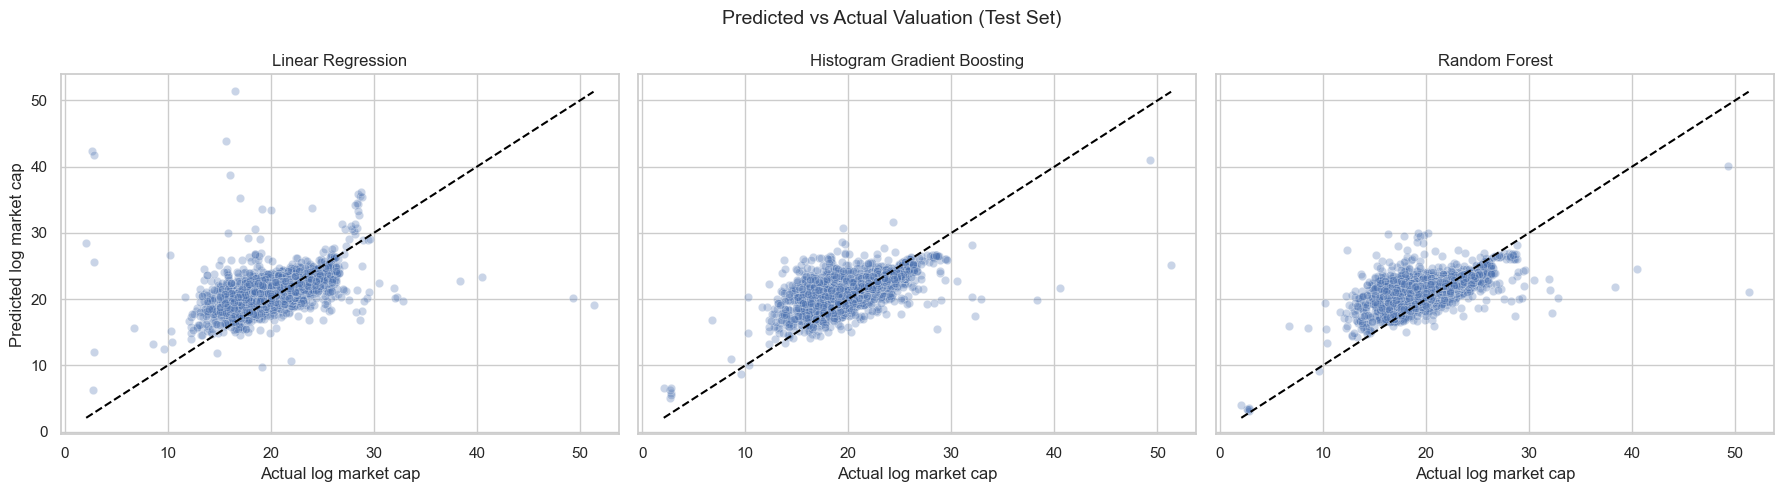

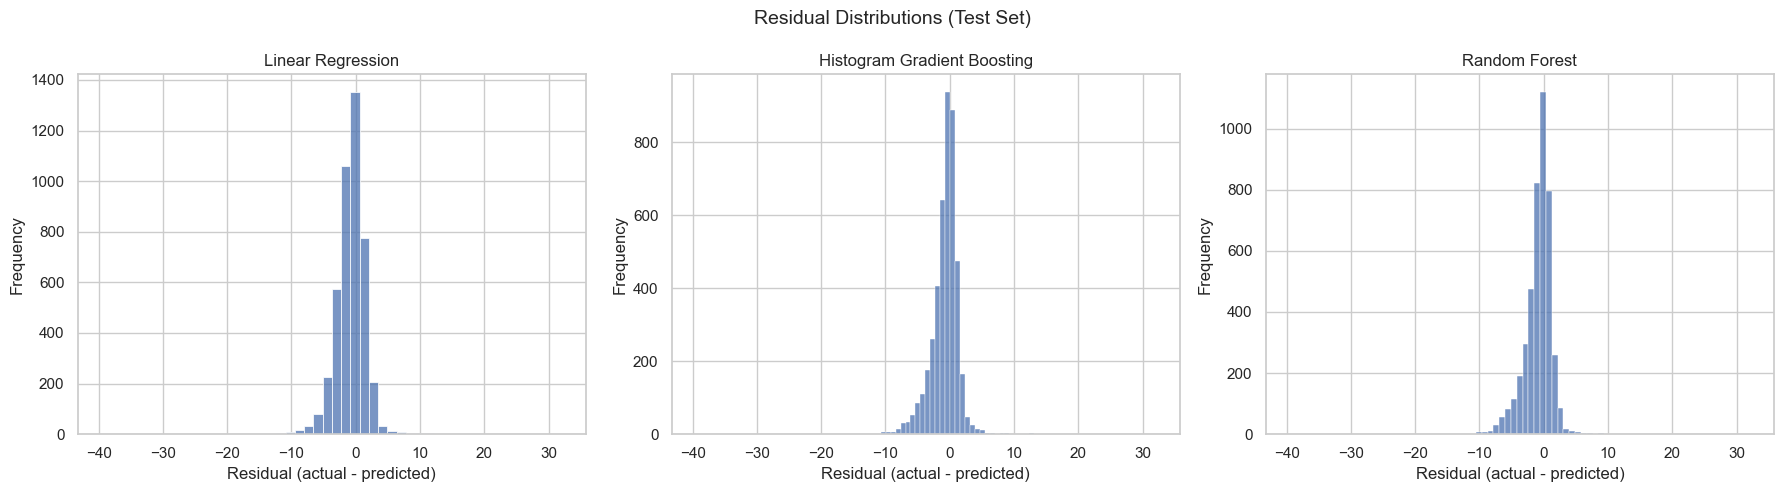

In [76]:
# -----------------------------------------
# SIDE-BY-SIDE: Predicted vs Actual
# -----------------------------------------
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (model_name, key) in zip(axes, model_keys.items()):
    pred_col = f"pred_{key}"
    
    sns.scatterplot(
        x=test_df["actual_log_mcap"],
        y=test_df[pred_col],
        alpha=0.3,
        ax=ax
    )
    ax.plot(
        [test_df["actual_log_mcap"].min(), test_df["actual_log_mcap"].max()],
        [test_df["actual_log_mcap"].min(), test_df["actual_log_mcap"].max()],
        linestyle="--",
        color="black"
    )
    ax.set_title(model_name)
    ax.set_xlabel("Actual log market cap")
    ax.set_ylabel("Predicted log market cap")

fig.suptitle("Predicted vs Actual Valuation (Test Set)", fontsize=14)
# fig.text(0.5, 0.04, "Actual log market cap", ha='center', fontsize=12)
# fig.text(0.04, 0.5, "Predicted log market cap", va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig("predicted_actual_valuation.pdf", dpi=300, bbox_inches='tight')
plt.show()


# -----------------------------------------
# SIDE-BY-SIDE: Residual Distributions
# -----------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for ax, (model_name, key) in zip(axes, model_keys.items()):
    resid_col = f"resid_{key}"
    
    sns.histplot(test_df[resid_col], bins=50, kde=False, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel("Residual (actual - predicted)")
    ax.set_ylabel("Frequency")

fig.suptitle("Residual Distributions (Test Set)", fontsize=14)
plt.tight_layout()
plt.savefig("residual_distributions.pdf", dpi=300, bbox_inches='tight')
plt.show()




In [77]:
# -----------------------------------------
# 1) Define validation / backtest universe
# -----------------------------------------
val_df = test_df.copy()
val_df["year"] = val_df["period"].dt.year

# Just to check:
print(val_df[["period", "year"]].head())
print(sorted(val_df["year"].unique()))

         period  year
6487 2019-12-31  2019
6433 2019-12-31  2019
4274 2019-12-31  2019
4356 2019-06-30  2019
985  2019-12-31  2019
[2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [78]:
def get_top_residuals_by_year(df, model_resid_col, year, top_n=2):
    """
    df: validation/backtest universe (val_df)
    model_resid_col: e.g. 'resid_histogram_gradient_boosting'
    """
    df_year = df[df["period"].dt.year == year].copy()
    df_year = df_year.dropna(subset=[model_resid_col, "close"])

    if df_year.empty:
        return None, None

    # Year t+1 universe (for exit prices)
    next_year_df = df[df["period"].dt.year == year + 1].copy()
    next_year_df = next_year_df.dropna(subset=["close"])

    if next_year_df.empty:
        return None, None

    valid_ciks = set(next_year_df["cik"])
    df_year = df_year[df_year["cik"].isin(valid_ciks)]

    if df_year.empty:
        return None, None

    undervalued = df_year.nsmallest(top_n, model_resid_col)
    overvalued = df_year.nlargest(top_n, model_resid_col)

    return undervalued, overvalued


In [79]:
def build_mispricing_signal_summary(df, years, resid_col, top_n=2):
    rows = []

    for year in years:
        undervalued, overvalued = get_top_residuals_by_year(
            df, resid_col, year, top_n=top_n
        )

        if undervalued is None or overvalued is None:
            continue

        long_tickers = list(undervalued["ticker"])
        short_tickers = list(overvalued["ticker"])

        row = {
            "year": year,
            "long_tickers": ", ".join(long_tickers),
            "short_tickers": ", ".join(short_tickers),
            "avg_residual_long": undervalued[resid_col].mean(),
            "avg_residual_short": overvalued[resid_col].mean(),
        }
        rows.append(row)

    return pd.DataFrame(rows)

years = [2019, 2020, 2021, 2022, 2023, 2024]  # 2025 has no 2026 exit prices

signal_lin = build_mispricing_signal_summary(
    val_df,
    years,
    resid_col="resid_linear_regression",
    top_n=2
)

signal_rf = build_mispricing_signal_summary(
    val_df,
    years,
    resid_col="resid_random_forest",
    top_n=2
)

signal_gb = build_mispricing_signal_summary(
    val_df,
    years,
    resid_col="resid_histogram_gradient_boosting",
    top_n=2
)

print("=== Linear Regression Mispricing Signal ===")
print(signal_lin.to_markdown(index=False))

print("\n=== Random Forest Mispricing Signal ===")
print(signal_rf.to_markdown(index=False))

print("\n=== Gradient Boosting Mispricing Signal ===")
print(signal_gb.to_markdown(index=False))


=== Linear Regression Mispricing Signal ===
|   year | long_tickers   | short_tickers   |   avg_residual_long |   avg_residual_short |
|-------:|:---------------|:----------------|--------------------:|---------------------:|
|   2019 | WDLF, BYOC     | BINI, ATDS      |           -12.4746  |             20.4247  |
|   2020 | PWDY, CTDD     | ATDS, MARA      |           -10.1213  |             11.5538  |
|   2021 | CTDD, ENZN     | ADTX, APVO      |           -20.5347  |             11.7025  |
|   2022 | CTDD, WHEN     | ADTX, LFLYD     |           -23.9281  |             12.4722  |
|   2023 | GXAI, CTDD     | ADTX, LFLYD     |           -27.3208  |             10.4602  |
|   2024 | AITX, VTGN     | ORCL, TTWO      |            -4.94312 |              2.62128 |

=== Random Forest Mispricing Signal ===
|   year | long_tickers   | short_tickers   |   avg_residual_long |   avg_residual_short |
|-------:|:---------------|:----------------|--------------------:|---------------------:|
|   2

In [80]:
initial_capital = 1_000_000

def run_portfolio_simulation(df, years, model_resid_col, top_n=2):
    portfolio_value = initial_capital
    history = []

    for year in years:
        undervalued, overvalued = get_top_residuals_by_year(
            df, model_resid_col, year, top_n=top_n
        )

        if undervalued is None or overvalued is None:
            print(f"No tradable names for year {year}.")
            continue

        undervalued = undervalued.reset_index(drop=True)
        overvalued = overvalued.reset_index(drop=True)

        enter_prices_long  = undervalued["close"].values.astype(float)
        enter_prices_short = overvalued["close"].values.astype(float)

        next_year_df = df[df["period"].dt.year == year + 1].copy()
        next_year_df = next_year_df.dropna(subset=["close"])

        cik_to_next_close = (
            next_year_df.drop_duplicates("cik")
                        .set_index("cik")["close"]
                        .to_dict()
        )

        exit_prices_long  = enter_prices_long.copy()
        exit_prices_short = enter_prices_short.copy()

        for pos, row in undervalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_long[pos] = cik_to_next_close[cik]

        for pos, row in overvalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_short[pos] = cik_to_next_close[cik]

        long_alloc_each  = portfolio_value * 0.5 / len(enter_prices_long)
        short_alloc_each = portfolio_value * 0.5 / len(enter_prices_short)

        long_shares  = long_alloc_each  / enter_prices_long
        short_shares = short_alloc_each / enter_prices_short

        pnl_long  = np.sum(long_shares  * (exit_prices_long  - enter_prices_long))
        pnl_short = np.sum(short_shares * (enter_prices_short - exit_prices_short))

        year_pnl = pnl_long + pnl_short
        portfolio_value = portfolio_value + year_pnl

        history.append({
            "year": year,
            "long_picks":  list(undervalued["ticker"]),
            "short_picks": list(overvalued["ticker"]),
            "pnl": float(year_pnl),
            "portfolio_value": float(portfolio_value),
        })

    return pd.DataFrame(history)


In [81]:
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]  # again, up to where year+1 exists

history_lin = run_portfolio_simulation(val_df, years, "resid_linear_regression")
history_rf  = run_portfolio_simulation(val_df, years, "resid_random_forest")
history_gb  = run_portfolio_simulation(val_df, years, "resid_histogram_gradient_boosting")

print("=== LR Portfolio History ===")
print(history_lin)

print("=== GB Portfolio History ===")
print(history_gb)

print("=== RFR Portfolio History ===")
print(history_rf)


No tradable names for year 2025.
No tradable names for year 2025.
No tradable names for year 2025.
=== LR Portfolio History ===
   year    long_picks    short_picks           pnl  portfolio_value
0  2019  [WDLF, BYOC]   [BINI, ATDS]  1.255606e+07     1.355606e+07
1  2020  [PWDY, CTDD]   [ATDS, MARA]  4.961441e+06     1.851750e+07
2  2021  [CTDD, ENZN]   [ADTX, APVO]  6.199444e+06     2.471694e+07
3  2022  [CTDD, WHEN]  [ADTX, LFLYD]  9.653840e+06     3.437078e+07
4  2023  [GXAI, CTDD]  [ADTX, LFLYD]  1.924223e+07     5.361301e+07
5  2024  [AITX, VTGN]   [ORCL, TTWO] -2.942100e+07     2.419201e+07
=== GB Portfolio History ===
   year    long_picks    short_picks           pnl  portfolio_value
0  2019  [WDLF, VXRT]   [ATDS, BINI]  1.297411e+07     1.397411e+07
1  2020  [PWDY, SDCH]   [ATDS, APVO]  3.751936e+06     1.772605e+07
2  2021  [BYOC, SDCH]   [ADTX, APVO]  7.013487e+06     2.473954e+07
3  2022  [TXMD, BNTC]  [ADTX, LFLYD]  2.654333e+06     2.739387e+07
4  2023   [TCRT, SLE]  [LFL

In [87]:
INITIAL_CAPITAL = 1_000_000

def build_shifted_equity_curve(history_df, start_year=2019, max_year=2025):
    """
    history_df: output from run_portfolio_simulation with columns
      ['year', 'portfolio_value', 'pnl', ...]
    start_year: the year at which we start with INITIAL_CAPITAL
    max_year: last year to show on the plot

    Returns: DataFrame with columns ['plot_year', 'portfolio_value']
    """
    df = history_df.copy()

    # PnL for trades in year t is reflected in portfolio_value at t
    # We want to *plot* that at year t+1
    df["plot_year"] = df["year"] + 1

    # Add the starting point (before any trades)
    start_row = pd.DataFrame({
        "plot_year": [start_year],
        "portfolio_value": [INITIAL_CAPITAL],
    })

    out = pd.concat([start_row, df[["plot_year", "portfolio_value"]]])
    out = out.sort_values("plot_year")
    out = out[out["plot_year"] <= max_year]

    return out

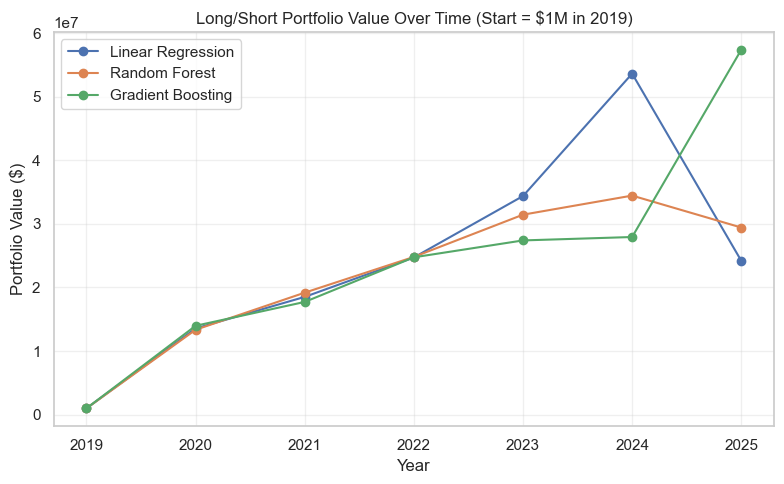

In [88]:
# lin_plot = build_shifted_equity_curve(history_lin, start_year=2019, max_year=2025)
# rf_plot  = build_shifted_equity_curve(history_rf,  start_year=2019, max_year=2025)
# gb_plot  = build_shifted_equity_curve(history_gb,  start_year=2019, max_year=2025)

# plt.figure(figsize=(8, 5))

# plt.plot(lin_plot["plot_year"], lin_plot["portfolio_value"], marker="o", label="Linear Regression")
# plt.plot(rf_plot["plot_year"],  rf_plot["portfolio_value"],  marker="o", label="Random Forest")
# plt.plot(gb_plot["plot_year"],  gb_plot["portfolio_value"],  marker="o", label="Gradient Boosting")

# plt.xlabel("Year")
# plt.ylabel("Portfolio Value ($)")
# plt.title("Long/Short Portfolio Value Over Time (Start = $1M in 2019)")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [85]:
import numpy as np
import pandas as pd

# ================================
# 1. Start from full feature df
# ================================
df_feat = meta["df_with_features"].copy()

# Market cap at price_date (close * shares)
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# Add filing year
df_large["year"] = df_large["period"].dt.year

# ================================
# 2. STAR logic inside large-cap universe
# ================================
required_years = set(range(2014, 2025))   # firms must exist in these years
pnl_years      = {2019, 2020, 2021, 2022, 2023, 2024, 2025}  # years where we actually trade (entry)

# Years where company exists in large-cap universe
years_all = (
    df_large.groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Years where company has price in large-cap universe
years_price = (
    df_large.dropna(subset=["close"])
            .groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Align indices
all_index = years_all.index.union(years_price.index)
years_all   = years_all.reindex(all_index, fill_value=set())
years_price = years_price.reindex(all_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_all.loc[cik]
    yrs_price = years_price.loc[cik]
    has_full_hist   = required_years.issubset(yrs_all)
    has_all_pnl_yrs = pnl_years.issubset(yrs_price)
    return has_full_hist and has_all_pnl_yrs

star_mask = pd.Series(all_index).apply(is_star)
star_mask.index = all_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Make cik explicit as a column for merging
star_df = star_df.reset_index().rename(columns={"index": "cik"})

print("Number of STAR large-cap companies:", int(star_df["star"].sum()))

# ================================
# 3. Build LARGE-CAP + STAR validation universe
# ================================
val_df = val_df.copy()
val_df["mcap"] = val_df["close"] * val_df["CommonSharesOutstanding"]

# Merge STAR info onto val_df
val_df_large = val_df.merge(star_df, on="cik", how="left")

# Non-large-cap / non-STAR companies -> star=0
val_df_large["star"] = val_df_large["star"].fillna(0).astype(int)

# Keep ONLY large-cap STAR rows
val_df_large_star = val_df_large[
    (val_df_large["star"] == 1) &
    (val_df_large["mcap"] > mcap_threshold)
].copy()

print("Validation rows (large-cap STAR only):", len(val_df_large_star))
print("Unique large-cap STAR ciks in validation:", val_df_large_star["cik"].nunique())
print(val_df_large_star[["cik", "ticker", "name"]].drop_duplicates().head())

# ================================
# 4. Run STAR-only portfolios for all 3 models
# ================================
validation_years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]  # 2025 would need 2026 prices

history_lin_star = run_portfolio_simulation(
    val_df_large_star, validation_years, "resid_linear_regression"
)
history_rf_star  = run_portfolio_simulation(
    val_df_large_star, validation_years, "resid_random_forest"
)
history_gb_star  = run_portfolio_simulation(
    val_df_large_star, validation_years, "resid_histogram_gradient_boosting"
)

print("\n=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== LARGE-CAP STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)



Number of STAR large-cap companies: 11
Validation rows (large-cap STAR only): 77
Unique large-cap STAR ciks in validation: 11
         cik ticker                   name
42    712515     EA   ELECTRONIC ARTS INC.
99   1166388   VRNT     VERINT SYSTEMS INC
140  1169561   CVLT  COMMVAULT SYSTEMS INC
150  1327811   WDAY          WORKDAY, INC.
256  1324948    RBC       RBC BEARINGS INC
No tradable names for year 2025.
No tradable names for year 2025.
No tradable names for year 2025.

=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===
   year    long_picks   short_picks            pnl  portfolio_value
0  2019  [NTCT, ORCL]    [VEEV, EA] -118905.800540     8.810942e+05
1  2020  [VRNT, NTCT]  [VEEV, TTWO]   95003.644648     9.760978e+05
2  2021  [NTCT, VRNT]    [VEEV, EA]  157128.508055     1.133226e+06
3  2022  [NTCT, VRNT]    [EA, VEEV]  -66880.008086     1.066346e+06
4  2023  [VRNT, CVLT]    [EA, TTWO]  137419.828590     1.203766e+06
5  2024  [NTCT, VRNT]  [ORCL, TTWO] -387659.049353

In [93]:
years = [2019, 2020, 2021, 2022, 2023, 2024]

signal_gb = build_mispricing_signal_summary(
    val_df_large_star,
    years,
    resid_col="resid_histogram_gradient_boosting",
    top_n=2
)

signal_lin = build_mispricing_signal_summary(
    val_df_large_star,
    years,
    resid_col="resid_linear_regression",
    top_n=2
)

signal_rf = build_mispricing_signal_summary(
    val_df_large_star,
    years,
    resid_col="resid_random_forest",
    top_n=2
)

print("=== Linear Regression Mispricing Signal ===")
print(signal_lin.to_markdown(index=False))


print("\n=== Gradient Boosting Mispricing Signal ===")
print(signal_gb.to_markdown(index=False))

print("\n=== Random Forest Mispricing Signal ===")
print(signal_rf.to_markdown(index=False))

=== Linear Regression Mispricing Signal ===
|   year | long_tickers   | short_tickers   |   avg_residual_long |   avg_residual_short |
|-------:|:---------------|:----------------|--------------------:|---------------------:|
|   2019 | NTCT, ORCL     | VEEV, EA        |          -0.295602  |              1.467   |
|   2020 | VRNT, NTCT     | VEEV, TTWO      |          -0.114846  |              1.74441 |
|   2021 | NTCT, VRNT     | VEEV, EA        |           0.464527  |              1.84747 |
|   2022 | NTCT, VRNT     | EA, VEEV        |           0.135905  |              1.75885 |
|   2023 | VRNT, CVLT     | EA, TTWO        |           0.0741651 |              2.66277 |
|   2024 | NTCT, VRNT     | ORCL, TTWO      |          -0.0465963 |              2.62128 |

=== Gradient Boosting Mispricing Signal ===
|   year | long_tickers   | short_tickers   |   avg_residual_long |   avg_residual_short |
|-------:|:---------------|:----------------|--------------------:|---------------------:|
|

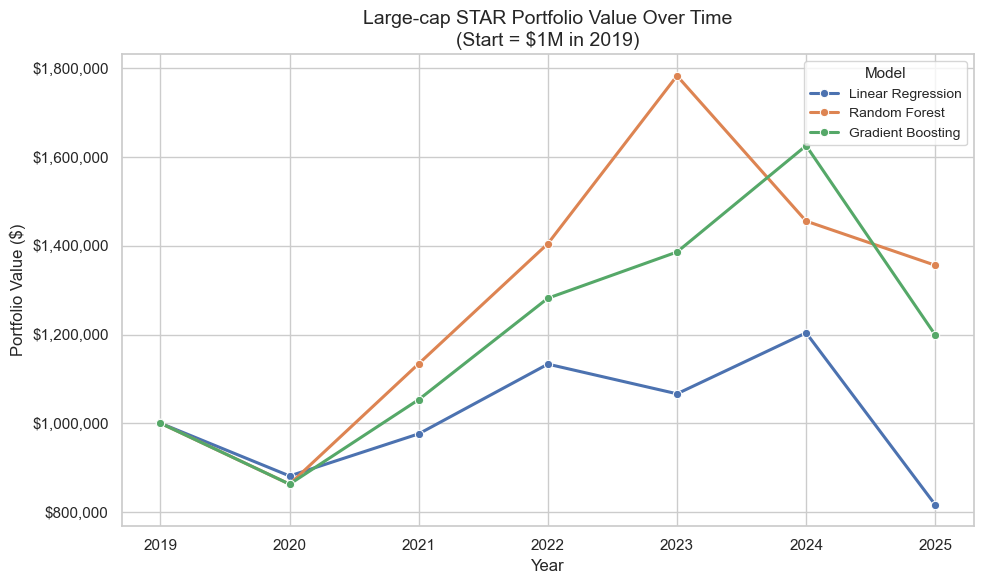

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------------------
# Build long-form DF for seaborn
# -----------------------------------------
def build_equity_curve_df(curve, model_name):
    df = curve.copy()
    df["Model"] = model_name
    return df[["plot_year", "portfolio_value", "Model"]]

df_lin = build_equity_curve_df(lin_star_plot, "Linear Regression")
df_rf  = build_equity_curve_df(rf_star_plot, "Random Forest")
df_gb  = build_equity_curve_df(gb_star_plot, "Gradient Boosting")

equity_curves = pd.concat([df_lin, df_rf, df_gb], ignore_index=True)

# -----------------------------------------
# Academic-style seaborn plot
# -----------------------------------------
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=equity_curves,
    x="plot_year",
    y="portfolio_value",
    hue="Model",
    marker="o",
    linewidth=2.2,
    palette="deep"
)

plt.title("Large-cap STAR Portfolio Value Over Time\n(Start = $1M in 2019)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)

# Format y-axis in millions for readability
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.xticks(equity_curves["plot_year"].unique())
plt.legend(title="Model", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.savefig("star_equity_curve_seaborn.pdf", dpi=300, bbox_inches="tight")
plt.show()


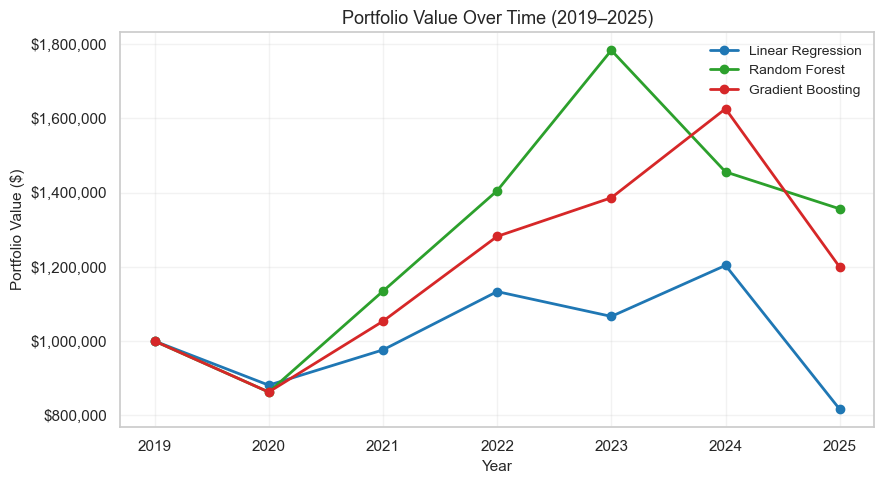

In [101]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- Choose palette ---
colors = {
    "Linear Regression": "#1f77b4",  
    "Random Forest":     "#2ca02c", 
    "Gradient Boosting": "#d62728"
}

plt.figure(figsize=(9, 5))

plt.plot(
    lin_star_plot["plot_year"], 
    lin_star_plot["portfolio_value"], 
    marker="o", linewidth=2,
    label="Linear Regression",
    color=colors["Linear Regression"]
)

plt.plot(
    rf_star_plot["plot_year"],  
    rf_star_plot["portfolio_value"],  
    marker="o", linewidth=2,
    label="Random Forest",
    color=colors["Random Forest"]
)

plt.plot(
    gb_star_plot["plot_year"],  
    gb_star_plot["portfolio_value"],  
    marker="o", linewidth=2,
    label="Gradient Boosting",
    color=colors["Gradient Boosting"]
)

# --- Axes + formatting ---
plt.xlabel("Year", fontsize=11)
plt.ylabel("Portfolio Value ($)", fontsize=11)

plt.title("Portfolio Value Over Time (2019–2025)", fontsize=13)

plt.grid(True, alpha=0.25)

# Format y-axis nicely (e.g., $1,200,000 → $1.2M)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

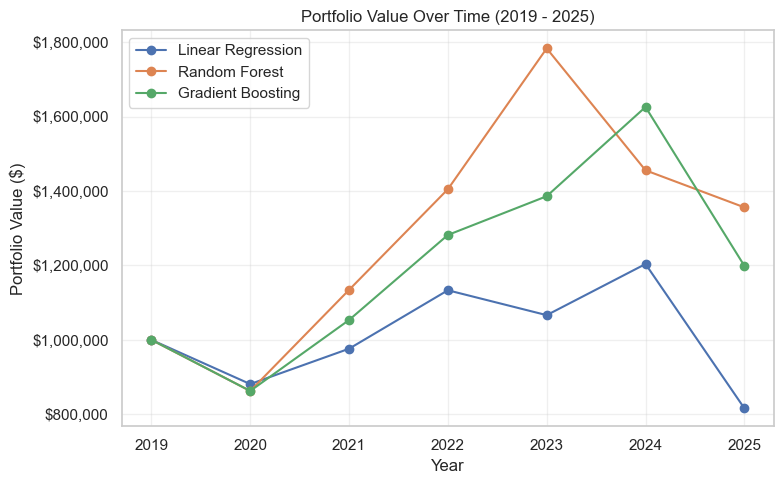

In [103]:
lin_star_plot = build_shifted_equity_curve(history_lin_star, start_year=2019, max_year=2025)
rf_star_plot  = build_shifted_equity_curve(history_rf_star,  start_year=2019, max_year=2025)
gb_star_plot  = build_shifted_equity_curve(history_gb_star,  start_year=2019, max_year=2025)

colors = {
    "Linear Regression": "#1f77b4",   # muted blue
    "Random Forest":     "#2ca02c",   # muted green
    "Gradient Boosting": "#d62728"    # muted red
}

plt.figure(figsize=(8, 5))

plt.plot(lin_star_plot["plot_year"], lin_star_plot["portfolio_value"], marker="o", label="Linear Regression")
plt.plot(rf_star_plot["plot_year"],  rf_star_plot["portfolio_value"],  marker="o", label="Random Forest")
plt.plot(gb_star_plot["plot_year"],  gb_star_plot["portfolio_value"],  marker="o", label="Gradient Boosting")

plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Time (2019 - 2025)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.savefig("portfolio_value_over_time.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [95]:
def summarise_portfolio(history_df, model_name):
    final_value = history_df["portfolio_value"].iloc[-1]
    total_return = (final_value / 1_000_000) - 1

    best_year = history_df.loc[history_df["pnl"].idxmax(), ["year", "pnl"]]
    worst_year = history_df.loc[history_df["pnl"].idxmin(), ["year", "pnl"]]

    return {
        "Model": model_name,
        "Final Value ($)": round(final_value, 2),
        "Total Return (%)": round(total_return * 100, 2),
        "Best Year": int(best_year["year"]),
        "Best Year PnL ($)": round(best_year["pnl"], 2),
        "Worst Year": int(worst_year["year"]),
        "Worst Year PnL ($)": round(worst_year["pnl"], 2)
    }

summary = pd.DataFrame([
    summarise_portfolio(history_lin_star, "Linear Regression"),
    summarise_portfolio(history_rf_star, "Random Forest"),
    summarise_portfolio(history_gb_star, "Gradient Boosting")
])

print(summary.to_markdown(index=False))


| Model             |   Final Value ($) |   Total Return (%) |   Best Year |   Best Year PnL ($) |   Worst Year |   Worst Year PnL ($) |
|:------------------|------------------:|-------------------:|------------:|--------------------:|-------------:|---------------------:|
| Linear Regression |  816107           |             -18.39 |        2021 |              157129 |         2024 |              -387659 |
| Random Forest     |       1.35607e+06 |              35.61 |        2022 |              378430 |         2023 |              -327626 |
| Gradient Boosting |       1.19894e+06 |              19.89 |        2023 |              239789 |         2024 |              -426813 |


In [106]:
import pandas as pd
import numpy as np

def compute_performance_stats(history_df, initial_capital=1_000_000):
    df = history_df.copy()
    df = df.sort_values("year")

    # Annual returns
    annual_returns = df["pnl"] / initial_capital

    # Annualised return (CAGR)
    start_value = initial_capital
    end_value = df["portfolio_value"].iloc[-1]
    num_years = len(df)

    cagr = (end_value / start_value) ** (1 / num_years) - 1

    # Annualised Sharpe (risk-free = 0)
    sharpe = annual_returns.mean() / annual_returns.std() if annual_returns.std() > 0 else np.nan

    # Max Drawdown
    curve = df["portfolio_value"]
    running_max = curve.cummax()
    drawdowns = (curve - running_max) / running_max
    max_drawdown = drawdowns.min()

    # Package results
    return {
        "Final Value ($)": end_value,
        "Total Return (%)": (end_value / start_value - 1) * 100,
        "CAGR (%)": cagr * 100,
        "Sharpe Ratio": sharpe,
        "Volatility (Annual %)": annual_returns.std() * 100,
        "Max Drawdown (%)": max_drawdown * 100
    }

lin_stats = compute_performance_stats(history_lin_star)
rf_stats  = compute_performance_stats(history_rf_star)
gb_stats  = compute_performance_stats(history_gb_star)

performance_table = pd.DataFrame([lin_stats, rf_stats, gb_stats],
                                 index=["Linear Regression", "Random Forest", "Gradient Boosting"])

print(performance_table.to_markdown())


|                   |   Final Value ($) |   Total Return (%) |   CAGR (%) |   Sharpe Ratio |   Volatility (Annual %) |   Max Drawdown (%) |
|:------------------|------------------:|-------------------:|-----------:|---------------:|------------------------:|-------------------:|
| Linear Regression |  816107           |           -18.3893 |   -3.33012 |      -0.147509 |                 20.7776 |           -32.2038 |
| Random Forest     |       1.35607e+06 |            35.6069 |    5.20756 |       0.208465 |                 28.4676 |           -23.9548 |
| Gradient Boosting |       1.19894e+06 |            19.8943 |    3.0702  |       0.125075 |                 26.5099 |           -26.2532 |


In [90]:
# import matplotlib.pyplot as plt
# def shift_portfolio_years(hist):
#     df = hist.copy()
#     df["plot_year"] = df["year"] + 1
#     return df

# lin_shifted = shift_portfolio_years(history_lin_star)
# rf_shifted  = shift_portfolio_years(history_rf_star)
# gb_shifted  = shift_portfolio_years(history_gb_star)

# INITIAL_CAPITAL = 1_000_000

# start_row = pd.DataFrame({
#     "plot_year": [2019],
#     "portfolio_value": [INITIAL_CAPITAL],
# })

# lin_plot = pd.concat([start_row, lin_shifted[["plot_year", "portfolio_value"]]])
# rf_plot  = pd.concat([start_row, rf_shifted[["plot_year", "portfolio_value"]]])
# gb_plot  = pd.concat([start_row, gb_shifted[["plot_year", "portfolio_value"]]])

# MAX_YEAR = 2025

# lin_plot = lin_plot[lin_plot["plot_year"] <= MAX_YEAR]
# rf_plot  = rf_plot[rf_plot["plot_year"] <= MAX_YEAR]
# gb_plot  = gb_plot[gb_plot["plot_year"] <= MAX_YEAR]


# plt.figure(figsize=(8, 5))

# plt.plot(lin_plot["plot_year"], lin_plot["portfolio_value"], marker="o", label="Linear Regression")
# plt.plot(rf_plot["plot_year"],  rf_plot["portfolio_value"],  marker="o", label="Random Forest")
# plt.plot(gb_plot["plot_year"],  gb_plot["portfolio_value"],  marker="o", label="Gradient Boosting")

# plt.xlabel("Year")
# plt.ylabel("Portfolio Value")
# plt.title("Large-cap STAR Portfolio Value Over Time (Shifted PnL Interpretation)")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [34]:
import numpy as np
import pandas as pd

INITIAL_CAPITAL = 1_000_000

def expand_history_to_trades(history_df, base_df, initial_capital=INITIAL_CAPITAL):
    """
    history_df: output of run_portfolio_simulation(...) 
                with columns: year, long_picks, short_picks, pnl, portfolio_value
    base_df:    the underlying validation dataframe used (e.g. val_df or val_df_large_star)
                must have: 'cik', 'ticker', 'period', 'close', and ideally 'price_date'
    """
    history_df = history_df.sort_values("year").reset_index(drop=True)
    trades = []

    years = history_df["year"].tolist()

    # Precompute start-of-year capital for each year
    start_capital = {}
    for i, row in history_df.iterrows():
        year = row["year"]
        if i == 0:
            start_capital[year] = initial_capital
        else:
            prev_year = history_df.loc[i-1, "year"]
            start_capital[year] = history_df.loc[i-1, "portfolio_value"]

    # We'll use price_date if it exists, otherwise fall back to period
    has_price_date = "price_date" in base_df.columns

    for i, row in history_df.iterrows():
        year = row["year"]
        long_tickers  = row["long_picks"]
        short_tickers = row["short_picks"]

        # Subset base_df for this year and next year
        df_year = base_df[base_df["period"].dt.year == year].copy()
        df_next = base_df[base_df["period"].dt.year == year + 1].copy()

        df_year = df_year.dropna(subset=["close"])
        df_next = df_next.dropna(subset=["close"])

        # For each year, if multiple rows per ticker, take the first by period
        df_year = df_year.sort_values("period").drop_duplicates("ticker")
        df_next = df_next.sort_values("period").drop_duplicates("cik")

        # Entry maps: ticker -> (cik, close, date)
        df_year_entry = df_year.copy()
        if has_price_date:
            df_year_entry["entry_date"] = df_year_entry["price_date"].fillna(df_year_entry["period"])
        else:
            df_year_entry["entry_date"] = df_year_entry["period"]

        entry_price_map = df_year_entry.set_index("ticker")["close"].to_dict()
        entry_date_map  = df_year_entry.set_index("ticker")["entry_date"].to_dict()
        ticker_to_cik   = df_year_entry.set_index("ticker")["cik"].to_dict()

        # Exit maps: cik -> (close, date)
        df_next_exit = df_next.copy()
        if has_price_date:
            df_next_exit["exit_date"] = df_next_exit["price_date"].fillna(df_next_exit["period"])
        else:
            df_next_exit["exit_date"] = df_next_exit["period"]

        exit_price_map = df_next_exit.set_index("cik")["close"].to_dict()
        exit_date_map  = df_next_exit.set_index("cik")["exit_date"].to_dict()

        # Capital at start of this year
        cap_start = start_capital[year]

        # Position sizing: 50% long, 50% short, equal within side
        n_long  = len(long_tickers)
        n_short = len(short_tickers)

        # Guard against weird cases
        if n_long == 0 or n_short == 0:
            continue

        long_alloc_each  = cap_start * 0.5 / n_long
        short_alloc_each = cap_start * 0.5 / n_short

        # ---- Long trades ----
        for ticker in long_tickers:
            if ticker not in entry_price_map:
                # No data for this ticker/year in base_df
                continue

            entry_price = float(entry_price_map[ticker])
            entry_date  = entry_date_map[ticker]
            cik         = ticker_to_cik[ticker]

            # Exit: if no next-year price, assume flat (exit = entry)
            exit_price = float(exit_price_map.get(cik, entry_price))
            exit_date  = exit_date_map.get(cik, entry_date)

            shares = long_alloc_each / entry_price
            pnl    = shares * (exit_price - entry_price)

            trades.append({
                "year": year,
                "ticker": ticker,
                "cik": cik,
                "side": "long",
                "entry_close_price": entry_price,
                "exit_close_price": exit_price,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "shares": float(shares),
                "pnl": float(pnl),
            })

        # ---- Short trades ----
        for ticker in short_tickers:
            if ticker not in entry_price_map:
                continue

            entry_price = float(entry_price_map[ticker])
            entry_date  = entry_date_map[ticker]
            cik         = ticker_to_cik[ticker]

            exit_price = float(exit_price_map.get(cik, entry_price))
            exit_date  = exit_date_map.get(cik, entry_date)

            shares = short_alloc_each / entry_price
            pnl    = shares * (entry_price - exit_price)  # short PnL

            trades.append({
                "year": year,
                "ticker": ticker,
                "cik": cik,
                "side": "short",
                "entry_close_price": entry_price,
                "exit_close_price": exit_price,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "shares": float(shares),
                "pnl": float(pnl),
            })

    trades_df = pd.DataFrame(trades)
    return trades_df


In [35]:
# history_lin_star, history_rf_star, history_gb_star already computed
# base df is val_df_large_star

trades_lin_star = expand_history_to_trades(history_lin_star, val_df_large_star)
trades_rf_star  = expand_history_to_trades(history_rf_star,  val_df_large_star)
trades_gb_star  = expand_history_to_trades(history_gb_star,  val_df_large_star)

print(trades_gb_star.head())

   year ticker      cik   side  entry_close_price  exit_close_price  \
0  2020   PEGA  1013857   long          70.877541         40.790321   
1  2020     BC    14930   long          82.452957         88.475388   
2  2020   LPSN  1102993  short         844.500000        352.799988   
3  2020   AMRN   897448  short         134.800003         64.000000   
4  2021   PEGA  1013857   long          40.790321         25.069813   

  entry_date  exit_date       shares            pnl  
0 2021-02-18 2022-02-17  3527.210424 -106123.953330  
1 2021-02-17 2022-02-17  3032.031944   18260.201416  
2 2021-03-09 2022-03-01   296.033156  145559.506278  
3 2021-02-26 2022-03-02  1854.599365  131305.640669  
4 2022-02-17 2023-02-16  7287.276465 -114559.692153  


## OLD ML MODEL CODE

### Models

Linear Regression (Time-based split):
  RMSE: 2.794954322335496
  MAE : 1.7889530184877644
  R²  : 0.06869201014908044


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


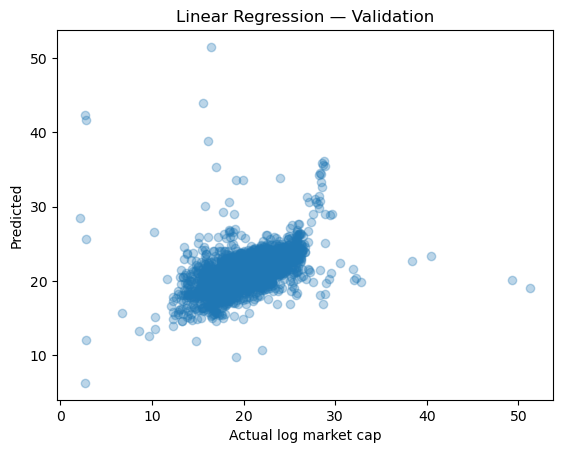

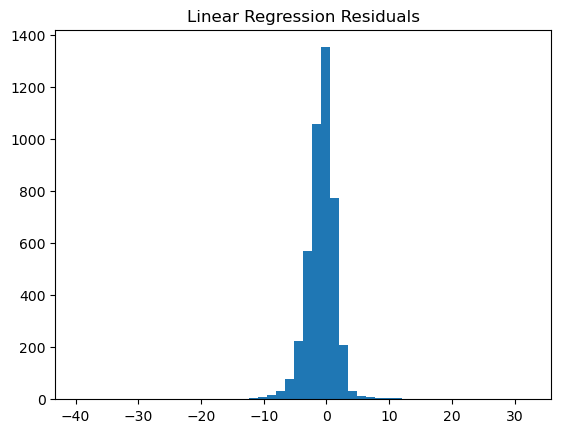

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ---------------------------------------------------
# 0) Start from your prepared data
# X, y, meta = prepare_ml_dataset(df)
# ---------------------------------------------------

# --- Base data from meta ---
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year
df_feat = df_feat.sort_values("year")

X_full = df_feat[meta["feature_names"]]
y_full = df_feat[meta["target_name"]]

# ---------------------------------------------------
# ✅ DROP BAD TICKERS HERE (MMCP rows)
# ---------------------------------------------------
bad_tickers = ["MMCP"]
mask_good = ~df_feat["ticker"].isin(bad_tickers)

df_feat = df_feat[mask_good]
X_full = X_full[mask_good]
y_full = y_full[mask_good]

# ---------------------------------------------------

# --- Time-based masks ---
train_mask = df_feat["year"] <= 2018
val_mask   = (df_feat["year"] >= 2019) & (df_feat["year"] <= 2025)

X_train, y_train = X_full[train_mask], y_full[train_mask]
X_val,   y_val   = X_full[val_mask],   y_full[val_mask]

# Drop rows where target is NaN
train_mask_valid = y_train.notna()
X_train, y_train = X_train[train_mask_valid], y_train[train_mask_valid]

val_mask_valid = y_val.notna()
X_val, y_val   = X_val[val_mask_valid], y_val[val_mask_valid]

# 3) Define numeric & categorical columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_full.columns]

numeric_cols = [c for c in X_full.columns if c not in categorical_cols]

# 4) Preprocess pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

# 6) Fit & evaluate
lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_val)

print("Linear Regression (Time-based split):")
print("  RMSE:", mean_squared_error(y_val, y_pred_lin, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_lin))
print("  R²  :", r2_score(y_val, y_pred_lin))

# --- Plots ---
plt.scatter(y_val, y_pred_lin, alpha=0.3)
plt.xlabel("Actual log market cap")
plt.ylabel("Predicted")
plt.title("Linear Regression — Validation")
plt.show()

plt.hist(y_val - y_pred_lin, bins=50)
plt.title("Linear Regression Residuals")
plt.show()


GRADIENT BOOSTING (VALIDATION)
  R²  : 0.3790353290743447
  RMSE: 2.282240964260959
  MAE : 1.5162037920496838


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


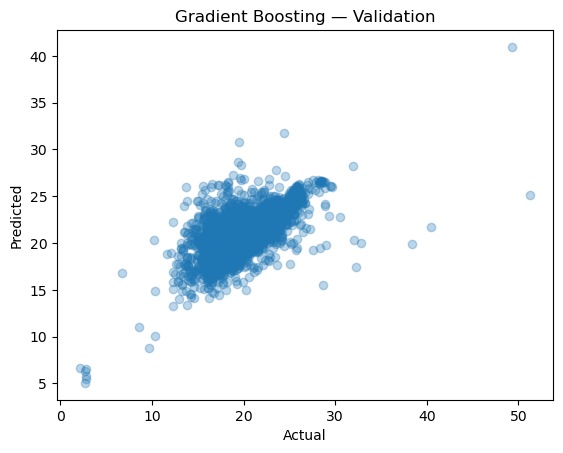

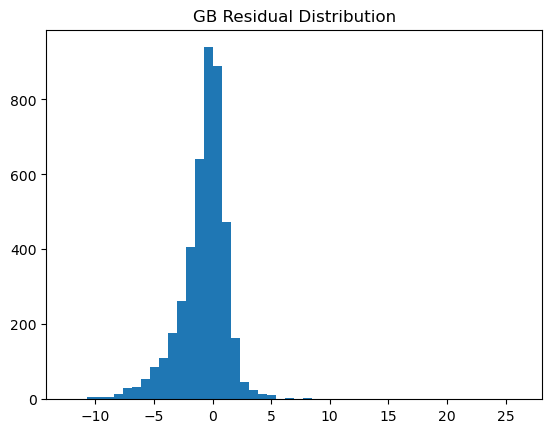

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
# ----- Gradient Boosting pipeline -----
categorical_transformer_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_gb, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0
    ))
])

gb_pipe.fit(X_train, y_train)
y_pred_val_gb = gb_pipe.predict(X_val)

print("\nGRADIENT BOOSTING (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_gb))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_gb, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_gb))

plt.scatter(y_val, y_pred_val_gb, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosting — Validation")
plt.show()

plt.hist(y_val - y_pred_val_gb, bins=50)
plt.title("GB Residual Distribution")
plt.show()

### Getting  the Resiuals from GB model - overvalued nad undervalued equities for each year

In [37]:
val_df = df_feat[val_mask].copy()

val_df["predicted_log_mcap"] = y_pred_val_gb
val_df["residual"] = val_df[meta["target_name"]] - val_df["predicted_log_mcap"]

for yr in [2019, 2020, 2021]:
    print("\n========================")
    print(f"YEAR: {yr}")
    print("========================")
    
    sub = val_df[val_df["year"] == yr].copy()
    
    # UNDERVALUE (most negative residuals)
    print("\nTop 5 Undervalued:")
    print(sub.nsmallest(5, "residual")[["cik", "name", "period", 
                                        meta["target_name"], 
                                        "predicted_log_mcap", 
                                        "residual"]])
    
    # OVERVALUED (most positive residuals)
    print("\nTop 5 Overvalued:")
    print(sub.nlargest(5, "residual")[["cik", "name", "period", 
                                       meta["target_name"], 
                                       "predicted_log_mcap", 
                                       "residual"]])


YEAR: 2019

Top 5 Undervalued:
          cik                         name     period  log_market_cap  \
3700  1281984    SOCIAL LIFE NETWORK, INC. 2019-12-31       10.245496   
279     72444                 VAXART, INC. 2019-12-31       18.279797   
4426  1386049        BEYOND COMMERCE, INC. 2019-12-31       14.217640   
5396  1515740       PREMIER BIOMEDICAL INC 2019-12-31       13.118379   
5491  1528172  ENDONOVO THERAPEUTICS, INC. 2019-12-31       12.091675   

      predicted_log_mcap   residual  
3700           20.281817 -10.036320  
279            26.406609  -8.126812  
4426           22.150402  -7.932762  
5396           20.026251  -6.907872  
5491           18.894233  -6.802558  

Top 5 Overvalued:
          cik                            name     period  log_market_cap  \
2713  1068689   DATA443 RISK MITIGATION, INC. 2019-12-31       28.657214   
5255  1499961               NET ELEMENT, INC. 2019-12-31       49.296969   
1979   946486  WINDTREE THERAPEUTICS INC /DE/ 2019-12-

### RandomForestRegressor

RANDOM FOREST (VALIDATION)
  R²  : 0.3319751300537448
  RMSE: 2.3671422978783943
  MAE : 1.5723768365194741


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


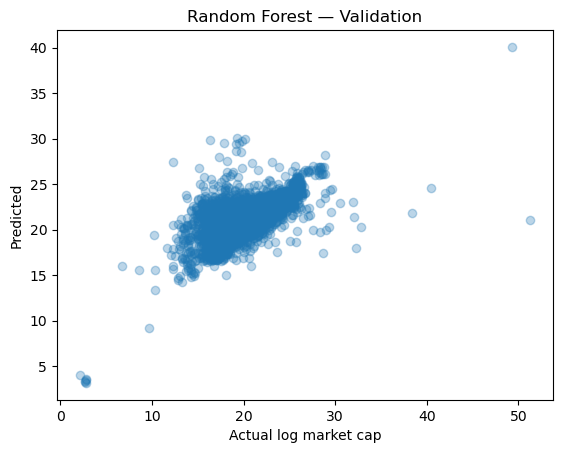

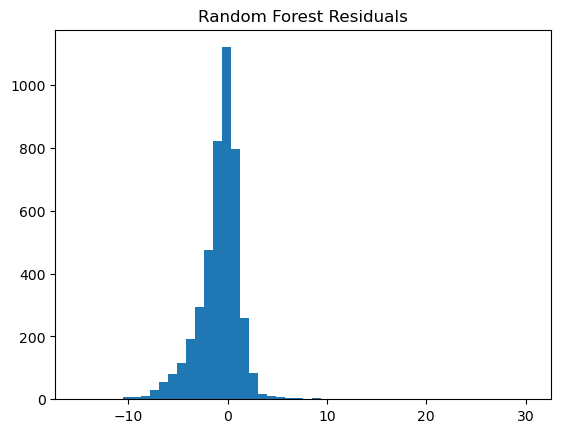

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ----- Random Forest pipeline -----
# Trees don't need scaling, just imputation.

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer_rf, categorical_cols),
    ]
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,       # or something like 10–20 if you want to regularise
        n_jobs=-1,
        random_state=42
    ))
])

# Fit on training set
rf_pipe.fit(X_train, y_train)

# Predict on validation set
y_pred_val_rf = rf_pipe.predict(X_val)

print("RANDOM FOREST (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_rf))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_rf, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_rf))

# ---- Visuals ----
# 1) Predicted vs Actual scatter
plt.scatter(y_val, y_pred_val_rf, alpha=0.3)
plt.xlabel("Actual log market cap")
plt.ylabel("Predicted")
plt.title("Random Forest — Validation")
plt.show()

# 2) Residual distribution
plt.hist(y_val - y_pred_val_rf, bins=50)
plt.title("Random Forest Residuals")
plt.show()

## Residuals

In [39]:
# Build validation dataframe aligned with X_val / y_val
# df_feat is meta["df_with_features"] with the original indices
val_df = df_feat.loc[X_val.index].copy()

target_col = meta["target_name"]  # e.g. "log_market_cap"

# Add actual target
val_df["actual_log_mcap"] = y_val

# Add predictions
val_df["pred_lin"] = y_pred_lin
val_df["pred_rf"]  = y_pred_val_rf
val_df["pred_gb"]  = y_pred_val_gb

# Add residuals: actual - predicted
val_df["resid_lin"] = val_df["actual_log_mcap"] - val_df["pred_lin"]
val_df["resid_rf"]  = val_df["actual_log_mcap"] - val_df["pred_rf"]
val_df["resid_gb"]  = val_df["actual_log_mcap"] - val_df["pred_gb"]

# (Optional) quick sanity peek
val_df[["cik", "name", "period",
        "actual_log_mcap", "pred_lin", "resid_lin",
        "pred_rf", "resid_rf",
        "pred_gb", "resid_gb"]].head()

,cik,name,period,actual_log_mcap,pred_lin,resid_lin,pred_rf,resid_rf,pred_gb,resid_gb
6487,1666071,"CARDLYTICS, INC.",2019-12-31,21.093545,20.867188,0.226358,19.676199,1.417346,19.798302,1.295243
6433,1659323,ITERUM THERAPEUTICS PLC,2019-12-31,19.875163,21.690186,-1.815023,22.638016,-2.762853,22.165808,-2.290646
4274,1368365,"REMARK HOLDINGS, INC.",2019-12-31,20.930629,21.350098,-0.419469,27.275205,-6.344576,25.719565,-4.788936
4356,1375365,"SUPER MICRO COMPUTER, INC.",2019-06-30,18.655187,20.962646,-2.307460,20.837070,-2.181883,21.087613,-2.432427
985,810509,"NAVIDEA BIOPHARMACEUTICALS, INC.",2019-12-31,16.530168,20.867188,-4.337019,21.663902,-5.133734,20.515541,-3.985373


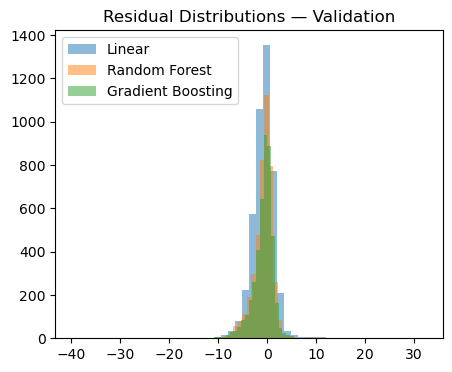

In [40]:
plt.figure(figsize=(5,4))
plt.hist(val_df["resid_lin"], bins=50, alpha=0.5, label="Linear")
plt.hist(val_df["resid_rf"],  bins=50, alpha=0.5, label="Random Forest")
plt.hist(val_df["resid_gb"],  bins=50, alpha=0.5, label="Gradient Boosting")
plt.legend()
plt.title("Residual Distributions — Validation")
plt.show()

## Overvalued/Undervalued?

In [41]:
validation_years = [2020, 2021, 2022, 2023, 2024, 2025]

In [46]:
def get_top_residuals_by_year(df, model_resid_col, year, top_n=2):
    """
    df: full validation dataframe (val_df)
    model_resid_col: e.g. 'resid_gb', 'resid_rf', 'resid_lin'
    
    Returns:
      undervalued, overvalued (both DataFrames) filtered to tickers
      that have a close price in year+1 as well.
    """
    # Universe for year t
    df_year = df[df["period"].dt.year == year].copy()
    df_year = df_year.dropna(subset=[model_resid_col, "close"])

    if df_year.empty:
        return None, None

    # Universe for year t+1 (must have price to close position)
    next_year_df = df[df["period"].dt.year == year + 1].copy()
    next_year_df = next_year_df.dropna(subset=["close"])

    if next_year_df.empty:
        # No next-year prices at all -> can't trade
        return None, None

    # Only keep tickers in year t that also have a close in year t+1
    valid_ciks = set(next_year_df["cik"])
    df_year = df_year[df_year["cik"].isin(valid_ciks)]

    if df_year.empty:
        return None, None

    # UNDERVALUE: most negative residuals → nsmallest
    undervalued = df_year.nsmallest(top_n, model_resid_col)

    # OVERVALUE: most positive residuals → nlargest
    overvalued = df_year.nlargest(top_n, model_resid_col)

    return undervalued, overvalued


In [47]:
import numpy as np
import pandas as pd

initial_capital = 1_000_000

def run_portfolio_simulation(val_df, validation_years, model_resid_col):
    portfolio_value = initial_capital
    history = []

    for year in validation_years:
        undervalued, overvalued = get_top_residuals_by_year(
            val_df, model_resid_col, year, top_n=2
        )

        if undervalued is None or overvalued is None:
            print(f"No tradable names for year {year} (missing next-year prices).")
            continue

        # Reset index so we can index arrays with 0,1,...
        undervalued = undervalued.reset_index(drop=True)
        overvalued = overvalued.reset_index(drop=True)

        # Entry prices at year t
        enter_prices_long  = undervalued["close"].values.astype(float)
        enter_prices_short = overvalued["close"].values.astype(float)

        # --- Next year prices (year + 1) ---
        next_year_df = val_df[val_df["period"].dt.year == year + 1]
        next_year_df = next_year_df.dropna(subset=["close"])

        cik_to_next_close = (
            next_year_df.drop_duplicates("cik")
                        .set_index("cik")["close"]
                        .to_dict()
        )

        # Exit prices (we expect ALL of these to be found, by construction)
        exit_prices_long  = enter_prices_long.copy()
        exit_prices_short = enter_prices_short.copy()

        for pos, row in undervalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_long[pos] = cik_to_next_close[cik]

        for pos, row in overvalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_short[pos] = cik_to_next_close[cik]

        # Sanity check: make sure exits are actually different where expected
        # (optional – just for debugging)
        # print(year, "long exits:", exit_prices_long, "short exits:", exit_prices_short)

        # Allocation: 50% long, 50% short, equal within each side
        long_alloc_each  = portfolio_value * 0.5 / len(enter_prices_long)
        short_alloc_each = portfolio_value * 0.5 / len(enter_prices_short)

        # Shares
        long_shares  = long_alloc_each  / enter_prices_long
        short_shares = short_alloc_each / enter_prices_short

        # P&L: longs = (exit - entry), shorts = (entry - exit)
        pnl_long  = np.sum(long_shares  * (exit_prices_long  - enter_prices_long))
        pnl_short = np.sum(short_shares * (enter_prices_short - exit_prices_short))

        year_pnl = pnl_long + pnl_short
        portfolio_value = portfolio_value + year_pnl

        history.append({
            "year": year,
            "long_picks":  list(undervalued["ticker"]),
            "short_picks": list(overvalued["ticker"]),
            "pnl": float(year_pnl),
            "portfolio_value": float(portfolio_value),
        })

    return pd.DataFrame(history)


In [48]:
history_lin = run_portfolio_simulation(val_df, validation_years, "resid_lin")
history_rf  = run_portfolio_simulation(val_df, validation_years, "resid_rf")
history_gb  = run_portfolio_simulation(val_df, validation_years, "resid_gb")

print("\n=== Linear Regression Portfolio ===")
print(history_lin)

print("\n=== Random Forest Portfolio ===")
print(history_rf)

print("\n=== Gradient Boosting Portfolio (Primary) ===")
print(history_gb)

No tradable names for year 2025 (missing next-year prices).
No tradable names for year 2025 (missing next-year prices).
No tradable names for year 2025 (missing next-year prices).

=== Linear Regression Portfolio ===
   year    long_picks    short_picks           pnl  portfolio_value
0  2020  [PWDY, CTDD]   [ATDS, MARA]  3.659943e+05     1.365994e+06
1  2021  [CTDD, ENZN]   [ADTX, APVO]  4.573191e+05     1.823313e+06
2  2022  [CTDD, WHEN]  [ADTX, LFLYD]  7.121421e+05     2.535455e+06
3  2023  [GXAI, CTDD]  [ADTX, LFLYD]  1.419456e+06     3.954911e+06
4  2024  [AITX, VTGN]   [ORCL, TTWO] -2.170321e+06     1.784591e+06

=== Random Forest Portfolio ===
   year     long_picks    short_picks            pnl  portfolio_value
0  2020  [DBVTF, WEWA]   [ATDS, APVO]  436761.062453     1.436761e+06
1  2021  [XOMAO, ALDS]   [ADTX, APVO]  420720.551361     1.857482e+06
2  2022   [ATNM, TXMD]  [ADTX, LFLYD]  497197.436492     2.354679e+06
3  2023   [INMB, GDLG]  [LFLYD, ESAB]  224745.236206     2.579

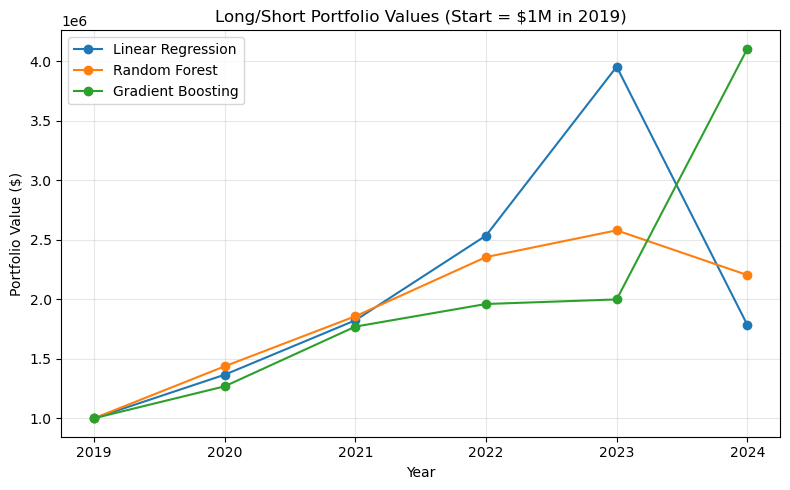

In [50]:
import matplotlib.pyplot as plt

INITIAL_CAPITAL = 1_000_000

def add_start_point(history_df, start_year=2019):
    start_row = pd.DataFrame({
        "year": [start_year],
        "portfolio_value": [INITIAL_CAPITAL],
        "pnl": [0.0]   # optional, for completeness
    })
    hist = pd.concat([start_row, history_df], ignore_index=True)
    return hist.sort_values("year")
lin_plot = add_start_point(history_lin)
rf_plot  = add_start_point(history_rf)
gb_plot  = add_start_point(history_gb)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(lin_plot["year"], lin_plot["portfolio_value"], marker="o", label="Linear Regression")
plt.plot(rf_plot["year"],  rf_plot["portfolio_value"],  marker="o", label="Random Forest")
plt.plot(gb_plot["year"],  gb_plot["portfolio_value"],  marker="o", label="Gradient Boosting")

plt.legend()
plt.title("Long/Short Portfolio Values (Start = $1M in 2019)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# plt.plot(history_lin["year"], history_lin["portfolio_value"], marker="o", label="Linear")
# plt.plot(history_rf["year"],  history_rf["portfolio_value"], marker="o", label="Random Forest")
# plt.plot(history_gb["year"],  history_gb["portfolio_value"], marker="o", label="HistGB")

# plt.legend()
# plt.title("Long/Short Portfolio Values (2020–2025)")
# plt.xlabel("Year")
# plt.ylabel("Portfolio Value ($)")
# plt.show()


## Large Cap Universe Portfolio

In [27]:
import numpy as np
import pandas as pd

# ================================
# 1. Start from full feature df
# ================================
df_feat = meta["df_with_features"].copy()

# Market cap at price_date (close * shares)
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# Add filing year
df_large["year"] = df_large["period"].dt.year

# ================================
# 2. STAR logic inside large-cap universe
# ================================
required_years = set(range(2014, 2025))   # full history condition
pnl_years      = {2020, 2021, 2022, 2023, 2024, 2025}       # years needed for entry/exit

# Years where company exists in large-cap universe
years_all = (
    df_large.groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Years where company has price in large-cap universe
years_price = (
    df_large.dropna(subset=["close"])
            .groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Align indices
all_index = years_all.index.union(years_price.index)
years_all   = years_all.reindex(all_index, fill_value=set())
years_price = years_price.reindex(all_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_all.loc[cik]
    yrs_price = years_price.loc[cik]
    has_full_hist   = required_years.issubset(yrs_all)
    has_all_pnl_yrs = pnl_years.issubset(yrs_price)
    return has_full_hist and has_all_pnl_yrs

star_mask = pd.Series(all_index).apply(is_star)
star_mask.index = all_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Make cik explicit as a column for merging
star_df = star_df.reset_index().rename(columns={"index": "cik"})

print("Number of STAR large-cap companies:", int(star_df["star"].sum()))

# ================================
# 3. Build validation LARGE-CAP + STAR dataframe
# ================================
# First ensure validation df has mcap too (for info / further filtering)
val_df = val_df.copy()
val_df["mcap"] = val_df["close"] * val_df["CommonSharesOutstanding"]

# Merge STAR info onto validation df
val_df_large = val_df.merge(star_df, on="cik", how="left")

# Non-large-cap / non-STAR companies will have NaN star → set to 0
val_df_large["star"] = val_df_large["star"].fillna(0).astype(int)

# Keep ONLY large-cap STAR rows: star=1 and mcap>threshold
val_df_large_star = val_df_large[
    (val_df_large["star"] == 1) &
    (val_df_large["mcap"] > mcap_threshold)
].copy()

print("Validation rows (large-cap STAR only):", len(val_df_large_star))
print("Unique large-cap STAR ciks in validation:", val_df_large_star["cik"].nunique())
print(val_df_large_star[["cik", "ticker", "name"]].drop_duplicates().head())

# ================================
# 4. Run STAR-only portfolios for all 3 models
# ================================
validation_years = [2020, 2021, 2022, 2023, 2024, 2025]

history_lin_star = run_portfolio_simulation(val_df_large_star, validation_years, "resid_lin")
history_rf_star  = run_portfolio_simulation(val_df_large_star, validation_years, "resid_rf")
history_gb_star  = run_portfolio_simulation(val_df_large_star, validation_years, "resid_gb")

print("\n=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== LARGE-CAP STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)

Number of STAR large-cap companies: 11
Validation rows (large-cap STAR only): 77
Unique large-cap STAR ciks in validation: 11
         cik ticker                   name
42    712515     EA   ELECTRONIC ARTS INC.
99   1166388   VRNT     VERINT SYSTEMS INC
140  1169561   CVLT  COMMVAULT SYSTEMS INC
150  1327811   WDAY          WORKDAY, INC.
256  1324948    RBC       RBC BEARINGS INC

=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===
   year    long_picks   short_picks            pnl  portfolio_value
0  2020  [VRNT, NTCT]  [VEEV, TTWO]  107824.617057     1.107825e+06
1  2021  [NTCT, VRNT]    [VEEV, EA]  178333.381552     1.286158e+06
2  2022  [NTCT, VRNT]    [EA, VEEV]  -75905.627488     1.210252e+06
3  2023  [VRNT, CVLT]    [EA, TTWO]  155964.967961     1.366217e+06
4  2024  [NTCT, VRNT]  [ORCL, TTWO] -439974.578870     9.262428e+05
5  2025  [VRNT, NTCT]    [TTWO, EA]       0.000000     9.262428e+05

=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===
   year    long_picks   sh

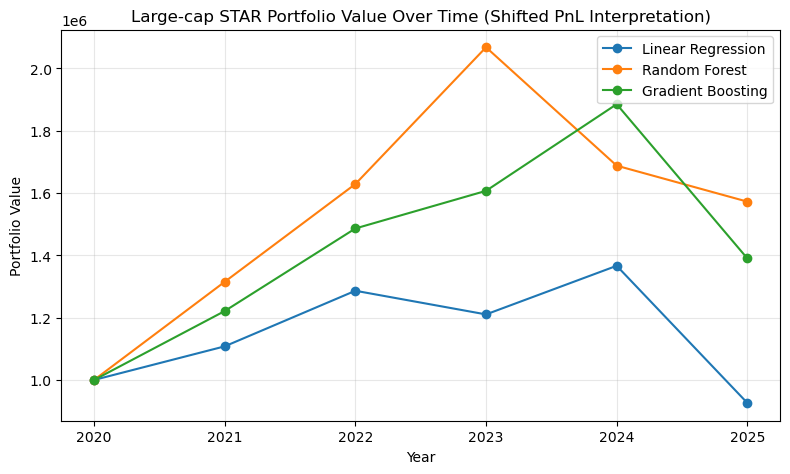

In [30]:
import matplotlib.pyplot as plt
def shift_portfolio_years(hist):
    df = hist.copy()
    df["plot_year"] = df["year"] + 1
    return df

lin_shifted = shift_portfolio_years(history_lin_star)
rf_shifted  = shift_portfolio_years(history_rf_star)
gb_shifted  = shift_portfolio_years(history_gb_star)

INITIAL_CAPITAL = 1_000_000

start_row = pd.DataFrame({
    "plot_year": [2020],
    "portfolio_value": [INITIAL_CAPITAL],
})

lin_plot = pd.concat([start_row, lin_shifted[["plot_year", "portfolio_value"]]])
rf_plot  = pd.concat([start_row, rf_shifted[["plot_year", "portfolio_value"]]])
gb_plot  = pd.concat([start_row, gb_shifted[["plot_year", "portfolio_value"]]])

MAX_YEAR = 2025

lin_plot = lin_plot[lin_plot["plot_year"] <= MAX_YEAR]
rf_plot  = rf_plot[rf_plot["plot_year"] <= MAX_YEAR]
gb_plot  = gb_plot[gb_plot["plot_year"] <= MAX_YEAR]


plt.figure(figsize=(8, 5))

plt.plot(lin_plot["plot_year"], lin_plot["portfolio_value"], marker="o", label="Linear Regression")
plt.plot(rf_plot["plot_year"],  rf_plot["portfolio_value"],  marker="o", label="Random Forest")
plt.plot(gb_plot["plot_year"],  gb_plot["portfolio_value"],  marker="o", label="Gradient Boosting")

plt.xlabel("Year")
plt.ylabel("Portfolio Value")
plt.title("Large-cap STAR Portfolio Value Over Time (Shifted PnL Interpretation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(8, 5))

# # Plot each model's portfolio value over time
# plt.plot(
#     history_lin_star["year"],
#     history_lin_star["portfolio_value"],
#     marker="o",
#     label="Linear Regression"
# )

# plt.plot(
#     history_rf_star["year"],
#     history_rf_star["portfolio_value"],
#     marker="o",
#     label="Random Forest"
# )

# plt.plot(
#     history_gb_star["year"],
#     history_gb_star["portfolio_value"],
#     marker="o",
#     label="Gradient Boosting"
# )

# plt.xlabel("Year")
# plt.ylabel("Portfolio value")
# plt.title("Large-cap STAR Portfolio Value Over Time")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [51]:
import numpy as np
import pandas as pd

INITIAL_CAPITAL = 1_000_000

def expand_history_to_trades(history_df, base_df, initial_capital=INITIAL_CAPITAL):
    """
    history_df: output of run_portfolio_simulation(...) 
                with columns: year, long_picks, short_picks, pnl, portfolio_value
    base_df:    the underlying validation dataframe used (e.g. val_df or val_df_large_star)
                must have: 'cik', 'ticker', 'period', 'close', and ideally 'price_date'
    """
    history_df = history_df.sort_values("year").reset_index(drop=True)
    trades = []

    years = history_df["year"].tolist()

    # Precompute start-of-year capital for each year
    start_capital = {}
    for i, row in history_df.iterrows():
        year = row["year"]
        if i == 0:
            start_capital[year] = initial_capital
        else:
            prev_year = history_df.loc[i-1, "year"]
            start_capital[year] = history_df.loc[i-1, "portfolio_value"]

    # We'll use price_date if it exists, otherwise fall back to period
    has_price_date = "price_date" in base_df.columns

    for i, row in history_df.iterrows():
        year = row["year"]
        long_tickers  = row["long_picks"]
        short_tickers = row["short_picks"]

        # Subset base_df for this year and next year
        df_year = base_df[base_df["period"].dt.year == year].copy()
        df_next = base_df[base_df["period"].dt.year == year + 1].copy()

        df_year = df_year.dropna(subset=["close"])
        df_next = df_next.dropna(subset=["close"])

        # For each year, if multiple rows per ticker, take the first by period
        df_year = df_year.sort_values("period").drop_duplicates("ticker")
        df_next = df_next.sort_values("period").drop_duplicates("cik")

        # Entry maps: ticker -> (cik, close, date)
        df_year_entry = df_year.copy()
        if has_price_date:
            df_year_entry["entry_date"] = df_year_entry["price_date"].fillna(df_year_entry["period"])
        else:
            df_year_entry["entry_date"] = df_year_entry["period"]

        entry_price_map = df_year_entry.set_index("ticker")["close"].to_dict()
        entry_date_map  = df_year_entry.set_index("ticker")["entry_date"].to_dict()
        ticker_to_cik   = df_year_entry.set_index("ticker")["cik"].to_dict()

        # Exit maps: cik -> (close, date)
        df_next_exit = df_next.copy()
        if has_price_date:
            df_next_exit["exit_date"] = df_next_exit["price_date"].fillna(df_next_exit["period"])
        else:
            df_next_exit["exit_date"] = df_next_exit["period"]

        exit_price_map = df_next_exit.set_index("cik")["close"].to_dict()
        exit_date_map  = df_next_exit.set_index("cik")["exit_date"].to_dict()

        # Capital at start of this year
        cap_start = start_capital[year]

        # Position sizing: 50% long, 50% short, equal within side
        n_long  = len(long_tickers)
        n_short = len(short_tickers)

        # Guard against weird cases
        if n_long == 0 or n_short == 0:
            continue

        long_alloc_each  = cap_start * 0.5 / n_long
        short_alloc_each = cap_start * 0.5 / n_short

        # ---- Long trades ----
        for ticker in long_tickers:
            if ticker not in entry_price_map:
                # No data for this ticker/year in base_df
                continue

            entry_price = float(entry_price_map[ticker])
            entry_date  = entry_date_map[ticker]
            cik         = ticker_to_cik[ticker]

            # Exit: if no next-year price, assume flat (exit = entry)
            exit_price = float(exit_price_map.get(cik, entry_price))
            exit_date  = exit_date_map.get(cik, entry_date)

            shares = long_alloc_each / entry_price
            pnl    = shares * (exit_price - entry_price)

            trades.append({
                "year": year,
                "ticker": ticker,
                "cik": cik,
                "side": "long",
                "entry_close_price": entry_price,
                "exit_close_price": exit_price,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "shares": float(shares),
                "pnl": float(pnl),
            })

        # ---- Short trades ----
        for ticker in short_tickers:
            if ticker not in entry_price_map:
                continue

            entry_price = float(entry_price_map[ticker])
            entry_date  = entry_date_map[ticker]
            cik         = ticker_to_cik[ticker]

            exit_price = float(exit_price_map.get(cik, entry_price))
            exit_date  = exit_date_map.get(cik, entry_date)

            shares = short_alloc_each / entry_price
            pnl    = shares * (entry_price - exit_price)  # short PnL

            trades.append({
                "year": year,
                "ticker": ticker,
                "cik": cik,
                "side": "short",
                "entry_close_price": entry_price,
                "exit_close_price": exit_price,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "shares": float(shares),
                "pnl": float(pnl),
            })

    trades_df = pd.DataFrame(trades)
    return trades_df


In [52]:
# history_lin_star, history_rf_star, history_gb_star already computed
# base df is val_df_large_star

trades_lin_star = expand_history_to_trades(history_lin_star, val_df_large_star)
trades_rf_star  = expand_history_to_trades(history_rf_star,  val_df_large_star)
trades_gb_star  = expand_history_to_trades(history_gb_star,  val_df_large_star)

print(trades_gb_star.head())


   year ticker      cik   side  entry_close_price  exit_close_price  \
0  2020   VRNT  1166388   long          18.609272         45.500000   
1  2020   CVLT  1169561   long          36.119999         68.870003   
2  2020   ADSK   769397  short         148.020004        265.959991   
3  2020   VEEV  1393052  short         156.369995        261.239990   
4  2021   SAIC  1571123   long          76.900749         86.516403   

  entry_date  exit_date        shares            pnl  
0 2020-04-01 2021-04-01  13434.163355  361254.432632  
1 2020-05-18 2021-05-14   6921.373405  226675.005421  
2 2020-03-20 2021-03-22   1688.960902 -199196.027190  
3 2020-03-31 2021-03-31   1598.772193 -167663.232065  
4 2021-03-29 2022-03-29   3969.630307   38170.591509  


In [54]:
trades_lin = expand_history_to_trades(history_lin, val_df)
trades_rf  = expand_history_to_trades(history_rf,  val_df)
trades_gb  = expand_history_to_trades(history_gb,  val_df)
print(trades_gb)

    year ticker      cik   side  entry_close_price  exit_close_price  \
0   2020   PWDY  1435617   long       4.000000e-04      4.000000e-04   
1   2020   SDCH  1022505   long       2.600000e-01      8.500000e-02   
2   2020   ATDS  1068689  short       9.884837e+04      3.810000e+03   
3   2020   APVO  1671584  short       9.217736e+05      1.976392e+05   
4   2021   BYOC  1386049   long       3.000000e-04      2.000000e-04   
5   2021   SDCH  1022505   long       8.500000e-02      1.100000e-01   
6   2021   ADTX  1726711  short       1.001180e+09      4.294000e+07   
7   2021   APVO  1671584  short       1.976392e+05      6.625960e+04   
8   2022   TXMD    25743   long       3.580000e+00      2.320000e+00   
9   2022   BNTC  1808898   long       1.055700e+01      3.050000e+00   
10  2022   ADTX  1726711  short       4.294000e+07      2.655500e+06   
11  2022  LFLYD  1785592  short       1.850000e+06      8.250000e+05   
12  2023   TCRT  1107421   long       1.760000e+01      2.160000

# ARCHIVED

## On test set

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ---------------------------------
# 1. Rebuild test split by YEAR
#    (train <= 2018, val 2019–2021, test >= 2022)
# ---------------------------------

df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Make sure X, y are aligned with df_feat index
X = X.copy()
y = y.copy()

# Define masks
train_mask = df_feat["year"] <= 2018
val_mask   = (df_feat["year"] >= 2019) & (df_feat["year"] <= 2021)
test_mask  = df_feat["year"] >= 2022

# Extract test set
X_test = X.loc[test_mask]
y_test = y.loc[test_mask]
test_df = df_feat.loc[test_mask].copy()

print("Test years present:", sorted(test_df["year"].unique()))
print("Test set size:", len(X_test))

# ---------------------------------
# 2. Evaluate all 3 models on TEST
#    (using existing fitted pipelines: lin_pipe, rf_pipe, gb_pipe)
# ---------------------------------

y_pred_test_lin = lin_pipe.predict(X_test)
y_pred_test_rf  = rf_pipe.predict(X_test)
y_pred_test_gb  = gb_pipe.predict(X_test)

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} (TEST)")
    print("  R²  :", r2)
    print("  RMSE:", rmse)
    print("  MAE :", mae)

print_metrics("Linear Regression", y_test, y_pred_test_lin)
print_metrics("Random Forest",     y_test, y_pred_test_rf)
print_metrics("Gradient Boosting", y_test, y_pred_test_gb)

# ---------------------------------
# 3. Build large-cap test universe and residuals
#    (mcap > 300M, equal-weight long/short strategy)
# ---------------------------------

# Actual log market cap
test_df["actual_log_mcap"] = y_test

# Predictions & residuals
test_df["pred_lin"] = y_pred_test_lin
test_df["pred_rf"]  = y_pred_test_rf
test_df["pred_gb"]  = y_pred_test_gb

test_df["resid_lin"] = test_df["actual_log_mcap"] - test_df["pred_lin"]
test_df["resid_rf"]  = test_df["actual_log_mcap"] - test_df["pred_rf"]
test_df["resid_gb"]  = test_df["actual_log_mcap"] - test_df["pred_gb"]

# Market cap and large-cap filter
test_df["mcap"] = test_df["close"] * test_df["CommonSharesOutstanding"]
mcap_threshold = 300_000_000
test_df_large = test_df[test_df["mcap"] > mcap_threshold].copy()

print("\nLarge-cap test rows:", len(test_df_large))
print("Unique large-cap ciks in test:", test_df_large["cik"].nunique())

# ---------------------------------
# 4. Run portfolio simulation on test years
#    using your existing run_portfolio_simulation()
#    Strategy: top 2 undervalued (long), top 2 overvalued (short) per year
# ---------------------------------

# Decide which test years can be used for trading:
# A year is tradable if we also have data for year+1 (to close the position).
all_test_years = sorted(test_df_large["year"].unique())
trade_years = [yr for yr in all_test_years if (yr + 1) in all_test_years]

print("Test trade years (entry years):", trade_years)

# Example run_portfolio_simulation signature assumed:
# run_portfolio_simulation(df, years, resid_col, initial_value=1_000_000, top_k=2)

history_lin_test = run_portfolio_simulation(test_df_large, trade_years, "resid_lin")
history_rf_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_rf")
history_gb_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_gb")

print("\n=== TEST — Linear Regression Portfolio (Large-cap) ===")
print(history_lin_test)

print("\n=== TEST — Random Forest Portfolio (Large-cap) ===")
print(history_rf_test)

print("\n=== TEST — Gradient Boosting Portfolio (Large-cap, Primary) ===")
print(history_gb_test)

Test years present: [2022, 2023, 2024, 2025]
Test set size: 2467

Linear Regression (TEST)
  R²  : -2.5668791842567004e+18
  RMSE: 4551661433.492995
  MAE : 129598620.80595209

Random Forest (TEST)
  R²  : 0.198712693620533
  RMSE: 2.543087878377334
  MAE : 1.7562187551777841

Gradient Boosting (TEST)
  R²  : 0.2700370935825359
  RMSE: 2.4272674513121975
  MAE : 1.6608390346870043

Large-cap test rows: 1550
Unique large-cap ciks in test: 637
Test trade years (entry years): [2022, 2023, 2024]

=== TEST — Linear Regression Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2022  [AAPL, MSFT]  [ADTX, LFLYD]  471229.002496     1.471229e+06
1  2023   [SYM, AAPL]   [MMCP, BINI]  -68056.512660     1.403172e+06
2  2024   [ALT, MSFT]    [LFLYD, VZ]       0.000000     1.403172e+06

=== TEST — Random Forest Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2022  [IBIO, SEGG]  [ADTX, LFLYD]  373052.98719

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visual of portoflio growth from 2019 - 2025

In [78]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# =====================================================
# 1) Base data + time-based split
# =====================================================

df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year
df_feat = df_feat.sort_values("year")

X_full = df_feat[meta["feature_names"]]
y_full = df_feat[meta["target_name"]]

# Time-based masks
train_mask = df_feat["year"] <= 2019   # TRAIN: up to 2018
test_mask  = df_feat["year"] >= 2020   # TEST: 2019 onwards (incl. your old val+test)

X_train, y_train = X_full[train_mask], y_full[train_mask]
X_test,  y_test  = X_full[test_mask],  y_full[test_mask]

# Drop rows where target is NaN (safety)
train_valid = y_train.notna()
X_train, y_train = X_train[train_valid], y_train[train_valid]

test_valid = y_test.notna()
X_test,  y_test  = X_test[test_valid],  y_test[test_valid]

print("Train years:", sorted(df_feat.loc[train_mask, "year"].unique()))
print("Test years:", sorted(df_feat.loc[test_mask,  "year"].unique()))
print("Train size:", len(X_train))
print("Test size :", len(X_test))

# =====================================================
# 2) Column types: numeric vs categorical
# =====================================================

# Infer categorical vs numeric from dtypes
categorical_cols = [c for c in X_full.columns if X_full[c].dtype == "object"]
numeric_cols     = [c for c in X_full.columns if c not in categorical_cols]

print("Numeric features   :", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

# =====================================================
# 3) Linear Regression pipeline
#    (impute + scale numerics, one-hot cats)
# =====================================================

numeric_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lin = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lin, numeric_cols),
        ("cat", categorical_transformer_lin, categorical_cols),
    ]
)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lin),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_test_lin = lin_pipe.predict(X_test)

# =====================================================
# 4) Random Forest pipeline
#    (impute numerics, one-hot cats, no scaling)
# =====================================================

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer_rf, categorical_cols),
    ]
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_test_rf = rf_pipe.predict(X_test)

# =====================================================
# 5) Gradient Boosting pipeline
#    (HistGradientBoostingRegressor + OneHot for cats)
# =====================================================

categorical_transformer_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_gb, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0,
        random_state=42
    ))
])

gb_pipe.fit(X_train, y_train)
y_pred_test_gb = gb_pipe.predict(X_test)

# =====================================================
# 6) Metrics helper and TEST results
# =====================================================

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} (TEST 2020+)")
    print("  R²  :", r2)
    print("  RMSE:", rmse)
    print("  MAE :", mae)

print_metrics("Linear Regression", y_test, y_pred_test_lin)
print_metrics("Random Forest",     y_test, y_pred_test_rf)
print_metrics("Gradient Boosting", y_test, y_pred_test_gb)


Train years: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test years: [2020, 2021, 2022, 2023, 2024, 2025]
Train size: 3605
Test size : 3862
Numeric features   : 76
Categorical features: 2

Linear Regression (TEST 2020+)
  R²  : -2.624296526746742e+18
  RMSE: 4601116847.073819
  MAE : 104706135.8596962

Random Forest (TEST 2020+)
  R²  : 0.36443853156107053
  RMSE: 2.2643084618472975
  MAE : 1.4891235699323557

Gradient Boosting (TEST 2020+)
  R²  : 0.482890866320155
  RMSE: 2.042433447706757
  MAE : 1.352954959197598


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [79]:
# df_feat already exists from your first cell and has mcap + year
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]
df_feat["year"] = df_feat["period"].dt.year

mcap_threshold = 300_000_000

# LARGE-CAP universe for STAR logic
df_large_all = df_feat[df_feat["mcap"] > mcap_threshold].copy()

FIRST_TRAIN_YEAR = 2009
FIRST_TEST_YEAR  = 2020
LAST_DATA_YEAR   = df_large_all["year"].max()   # likely 2024

required_years = set(range(FIRST_TRAIN_YEAR, LAST_DATA_YEAR + 1))
pnl_years      = set(range(FIRST_TEST_YEAR,  LAST_DATA_YEAR + 1))

years_all = (
    df_large_all.groupby("cik")["year"]
                .agg(lambda s: set(s))
)

years_price = (
    df_large_all.dropna(subset=["close"])
                .groupby("cik")["year"]
                .agg(lambda s: set(s))
)

all_index = years_all.index.union(years_price.index)
years_all   = years_all.reindex(all_index, fill_value=set())
years_price = years_price.reindex(all_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_all.loc[cik]
    yrs_price = years_price.loc[cik]
    has_full_hist   = required_years.issubset(yrs_all)
    has_all_pnl_yrs = pnl_years.issubset(yrs_price)
    return has_full_hist and has_all_pnl_yrs

star_mask = pd.Series(all_index).apply(is_star)
star_mask.index = all_index

star_df = (
    star_mask.astype(int)
             .rename("star")
             .to_frame()
             .reset_index()
             .rename(columns={"index": "cik"})
)

print("Number of STAR large-cap companies:", int(star_df["star"].sum()))


Number of STAR large-cap companies: 0


In [70]:
import numpy as np
import pandas as pd

# ------------------------------------------------
# 1) Build test_df with predictions + residuals
#    (test_mask is: df_feat["year"] >= 2019)
# ------------------------------------------------

test_df = df_feat.loc[test_mask].copy()   # years >= 2019
test_df["year"] = test_df["period"].dt.year

# Align y_test and predictions by index
test_df["actual_log_mcap"] = y_test

test_df["pred_lin"] = y_pred_test_lin
test_df["pred_rf"]  = y_pred_test_rf
test_df["pred_gb"]  = y_pred_test_gb

test_df["resid_lin"] = test_df["actual_log_mcap"] - test_df["pred_lin"]
test_df["resid_rf"]  = test_df["actual_log_mcap"] - test_df["pred_rf"]
test_df["resid_gb"]  = test_df["actual_log_mcap"] - test_df["pred_gb"]

# ------------------------------------------------
# 2) Large-cap filter (mcap > 300M)
# ------------------------------------------------

test_df["mcap"] = test_df["close"] * test_df["CommonSharesOutstanding"]
mcap_threshold = 300_000_000

test_df_large = test_df[test_df["mcap"] > mcap_threshold].copy()

print("Large-cap test rows:", len(test_df_large))
print("Unique large-cap ciks in test:", test_df_large["cik"].nunique())
print("Test years present in large-cap subset:", sorted(test_df_large["year"].unique()))

# ------------------------------------------------
# 3) Choose trade years: 2019–2024
#    Only years where year+1 also exists (to close positions)
# ------------------------------------------------

all_test_years = sorted(test_df_large["year"].unique())

candidate_years = [yr for yr in all_test_years if (yr + 1) in all_test_years]
trade_years = [yr for yr in candidate_years if 2020 <= yr <= 2025]

print("Test trade years (entry years):", trade_years)

# ------------------------------------------------
# 4) Run portfolio simulation for all 3 models
#    using your existing run_portfolio_simulation(...)
#    Strategy: top 2 undervalued (long), top 2 overvalued (short)
# ------------------------------------------------

history_lin_test = run_portfolio_simulation(test_df_large, trade_years, "resid_lin")

history_rf_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_rf")
history_gb_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_gb"
)

print("\n=== TEST — Linear Regression Portfolio (Large-cap) ===")
print(history_lin_test)

print("\n=== TEST — Random Forest Portfolio (Large-cap) ===")
print(history_rf_test)

print("\n=== TEST — Gradient Boosting Portfolio (Large-cap, Primary) ===")
print(history_gb_test)

Large-cap test rows: 2593
Unique large-cap ciks in test: 751
Test years present in large-cap subset: [2020, 2021, 2022, 2023, 2024, 2025]
Test trade years (entry years): [2020, 2021, 2022, 2023, 2024]

=== TEST — Linear Regression Portfolio (Large-cap) ===
   year     long_picks    short_picks            pnl  portfolio_value
0  2020   [GERN, CRDF]   [BINI, ATDS]  148794.263770     1.148794e+06
1  2021  [ZOMDF, AAPL]   [ADTX, APVO]  475895.860438     1.624690e+06
2  2022   [AAPL, MSFT]  [ADTX, LFLYD]  765601.106597     2.390291e+06
3  2023    [SYM, AAPL]   [MMCP, BINI] -110570.744006     2.279720e+06
4  2024    [ALT, AAPL]    [LFLYD, VZ]       0.000000     2.279720e+06

=== TEST — Random Forest Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2020  [CVTV, TTNP]   [BINI, ATDS]  240364.028996     1.240364e+06
1  2021  [ARCT, AVIR]   [ADTX, APVO]  483621.278374     1.723985e+06
2  2022  [SEGG, IBIO]  [ADTX, LFLYD]  643137.868799     2.367123

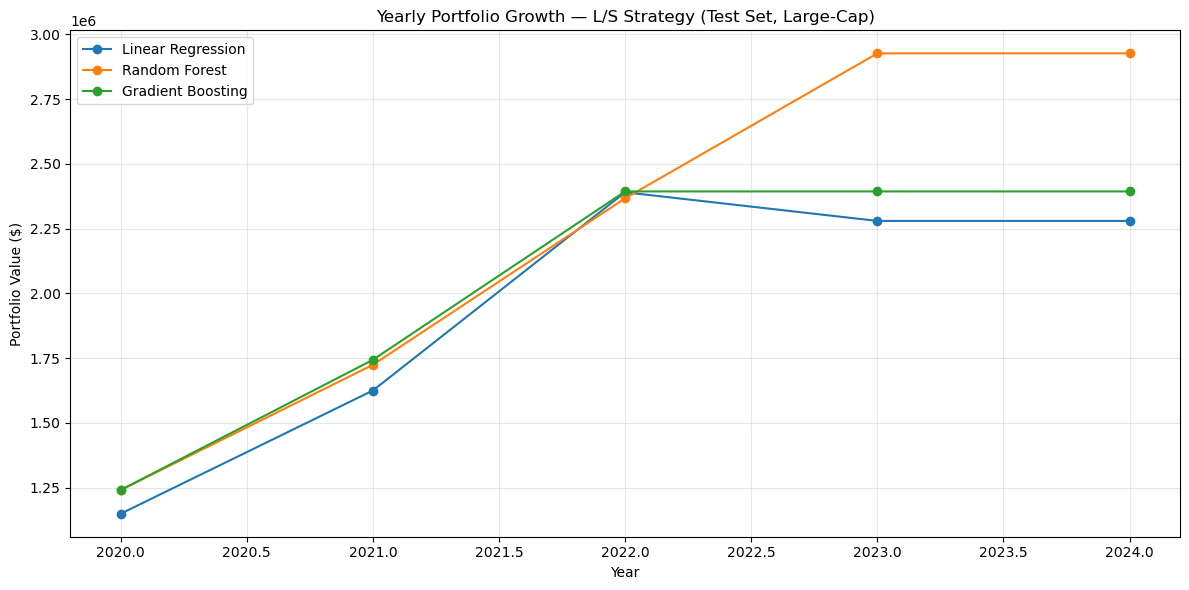

In [71]:
import matplotlib.pyplot as plt

# Put your tables into DataFrames (if not already)
lin = history_lin_test      # Linear Regression DF
rf  = history_rf_test       # Random Forest DF
gb  = history_gb_test       # Gradient Boosting DF

plt.figure(figsize=(12,6))

# Plot portfolio values for each model
plt.plot(lin["year"], lin["portfolio_value"], marker='o', label="Linear Regression")
plt.plot(rf["year"],  rf["portfolio_value"],  marker='o', label="Random Forest")
plt.plot(gb["year"],  gb["portfolio_value"],  marker='o', label="Gradient Boosting")

plt.title("Yearly Portfolio Growth — L/S Strategy (Test Set, Large-Cap)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
import numpy as np
import pandas as pd

def build_positions_table(val_df, validation_years, model_resid_col, model_name="model", top_n=2):
    """
    Returns a tidy DataFrame with one row per position:

    columns: [
      'model', 'resid_col', 'ticker', 'cik', 'side',
      'entry_year', 'exit_year',
      'entry_date', 'exit_date',
      'entry_price', 'exit_price'
    ]
    """

    df = val_df.copy()
    df["year"] = df["period"].dt.year

    records = []

    for year in validation_years:
        entry_year = year
        exit_year = year + 1

        undervalued, overvalued = get_top_residuals_by_year(df, model_resid_col, entry_year, top_n=top_n)
        if undervalued is None or overvalued is None:
            continue

        # mark sides
        undervalued = undervalued.copy()
        overvalued = overvalued.copy()
        undervalued["side"] = "long"
        overvalued["side"] = "short"

        picks = pd.concat([undervalued, overvalued], ignore_index=True)

        # next-year data for exits
        next_year_df = df[df["year"] == exit_year].dropna(subset=["close"]).copy()
        if next_year_df.empty:
            # no exit info for this year at all
            cik_to_exit = {}
        else:
            # sort so "first occurrence" is earliest in the year
            next_year_df = next_year_df.sort_values("period")

            # cik → (exit_date, exit_price)
            cik_to_exit = (
                next_year_df.drop_duplicates("cik", keep="first")
                            .set_index("cik")[["period", "close"]]
                            .to_dict(orient="index")
            )

        # now create one record per position
        for _, row in picks.iterrows():
            cik = row["cik"]
            tkr = row["ticker"]

            entry_date = row["period"]
            entry_price = float(row["close"])

            if cik in cik_to_exit:
                exit_date  = cik_to_exit[cik]["period"]
                exit_price = float(cik_to_exit[cik]["close"])
            else:
                exit_date  = pd.NaT
                exit_price = np.nan

            records.append({
                "model": model_name,
                "resid_col": model_resid_col,
                "ticker": tkr,
                "cik": cik,
                "side": row["side"],
                "entry_year": entry_year,
                "exit_year": exit_year,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "entry_price": entry_price,
                "exit_price": exit_price,
            })

    if not records:
        return pd.DataFrame()

    positions = pd.DataFrame(records)

    # optional: add months + simple return
    positions["entry_month"] = positions["entry_date"].dt.month
    positions["exit_month"]  = positions["exit_date"].dt.month

    def pos_ret(r):
        if np.isnan(r["exit_price"]):
            return np.nan
        if r["side"] == "long":
            return r["exit_price"] / r["entry_price"] - 1.0
        else:
            return r["entry_price"] / r["exit_price"] - 1.0

    positions["return"] = positions.apply(pos_ret, axis=1)

    return positions


In [77]:
lin_positions = build_positions_table(
    val_df=test_df_large,           # or whatever df you use
    validation_years=trade_years,   # [2019, 2020, ...]
    model_resid_col="resid_lin",
    model_name="Linear",
    top_n=2
)

rf_positions = build_positions_table(
    test_df_large, trade_years, "resid_rf", model_name="RandomForest", top_n=2
)

gb_positions = build_positions_table(
    test_df_large, trade_years, "resid_gb", model_name="GradientBoosting", top_n=2
)

print(lin_positions)
print(100*'-')
print(rf_positions)
print(100*'-')
print(gb_positions)

     model  resid_col ticker      cik   side  entry_year  exit_year  \
0   Linear  resid_lin   GERN   886744   long        2020       2021   
1   Linear  resid_lin   CRDF  1213037   long        2020       2021   
2   Linear  resid_lin   BINI  1499961  short        2020       2021   
3   Linear  resid_lin   ATDS  1068689  short        2020       2021   
4   Linear  resid_lin  ZOMDF  1684144   long        2021       2022   
5   Linear  resid_lin   AAPL   320193   long        2021       2022   
6   Linear  resid_lin   ADTX  1726711  short        2021       2022   
7   Linear  resid_lin   APVO  1671584  short        2021       2022   
8   Linear  resid_lin   AAPL   320193   long        2022       2023   
9   Linear  resid_lin   MSFT   789019   long        2022       2023   
10  Linear  resid_lin   ADTX  1726711  short        2022       2023   
11  Linear  resid_lin  LFLYD  1785592  short        2022       2023   
12  Linear  resid_lin    SYM  1837240   long        2023       2024   
13  Li

# Archived

## Markowitz Portfolio Construction

In [ ]:
import numpy as np
import pandas as pd

# Start from full feature df
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Market cap at price_date
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# --- Compute 1-year forward returns for large caps ---

# Keep only necessary columns
price_cols = df_large[["cik", "ticker", "year", "close"]].copy()

# Next-year close per cik
next_year = price_cols.copy()
next_year["year"] = next_year["year"] - 1   # shift year so we can merge t with t+1
next_year = next_year.rename(columns={"close": "next_close"})

# Merge to align year t with year t+1 close
returns_df = price_cols.merge(
    next_year[["cik", "year", "next_close"]],
    on=["cik", "year"],
    how="left"
)

# Forward simple return
returns_df["fwd_return"] = (returns_df["next_close"] - returns_df["close"]) / returns_df["close"]

# Keep only years where forward return is defined (i.e., we have next year's price)
returns_df = returns_df.dropna(subset=["fwd_return"])

In [ ]:
# Restrict validation df to large-cap only
val_df_large = val_df.copy()
val_df_large["mcap"] = val_df_large["close"] * val_df_large["CommonSharesOutstanding"]
val_df_large = val_df_large[val_df_large["mcap"] > mcap_threshold].copy()

val_df_large["year"] = val_df_large["period"].dt.year

# Choose how many BUY picks per year
TOP_K = 5

buy_universe = []

for yr in [2019, 2020]:
    year_slice = val_df_large[val_df_large["year"] == yr]
    # More negative residual = more undervalued
    top_buy = year_slice.sort_values("resid_gb").head(TOP_K)
    buy_universe.append(top_buy[["cik", "ticker"]])

buy_universe = pd.concat(buy_universe).drop_duplicates().reset_index(drop=True)
print("BUY universe (GB, large-cap):")
print(buy_universe)


In [ ]:
# Merge to get forward returns for BUY universe
buy_returns = returns_df.merge(
    buy_universe,
    on=["cik", "ticker"],
    how="inner"
)

# Keep only validation years
buy_returns = buy_returns[buy_returns["year"].isin([2019, 2020])].copy()

# Pivot to Year x Ticker matrix
R = buy_returns.pivot_table(
    index="year",
    columns="ticker",
    values="fwd_return"
)

print("Return matrix R (rows: years, cols: tickers):")
print(R)

In [ ]:
R = R.dropna(axis=1, how="any")  # require both years have returns
print("After dropping incomplete columns, assets for Markowitz:", R.columns.tolist())

mu = R.mean(axis=0).values        # expected returns (mean over years)
Sigma = R.cov().values            # covariance matrix (NxN)
tickers_m = R.columns.tolist()
N = len(tickers_m)
print("N assets in Markowitz universe:", N)


In [ ]:
import numpy as np

ones = np.ones(N)

# Unconstrained min-variance solution: w ∝ Σ^{-1} 1
Sigma_inv = np.linalg.pinv(Sigma)
w_raw = Sigma_inv @ ones
w_raw = w_raw / (ones @ w_raw)   # normalize to sum to 1

# Enforce long-only by clipping negatives and renormalising
w_long_only = np.clip(w_raw, 0, None)
if w_long_only.sum() == 0:
    # fallback: equal weight if everything got clipped
    w_long_only = np.ones(N) / N
else:
    w_long_only = w_long_only / w_long_only.sum()

print("\nMarkowitz long-only weights:")
for t, w in zip(tickers_m, w_long_only):
    print(f"{t}: {w:.3f}")

In [ ]:
# Portfolio returns per year
port_ret_marko = R.values @ w_long_only           # (2, N) @ (N,) -> (2,)
w_eq = np.ones(N) / N
port_ret_eq = R.values @ w_eq

results = pd.DataFrame({
    "year": R.index,
    "ret_markowitz": port_ret_marko,
    "ret_equal_weight": port_ret_eq
})

results["value_markowitz"] = (1 + results["ret_markowitz"]).cumprod()
results["value_equal_weight"] = (1 + results["ret_equal_weight"]).cumprod()

print("\nMarkowitz vs Equal-Weight performance (starting at 1.0):")
print(results)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(results["year"], results["value_markowitz"], "o-", label="Markowitz (GB BUYs)")
plt.plot(results["year"], results["value_equal_weight"], "o--", label="Equal-Weight (GB BUYs)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value (starting at 1.0)")
plt.title("Markowitz vs Equal-Weight on Large-Cap GB BUYs (2019–2020)")
plt.legend()
plt.tight_layout()
plt.show()

## Star Companies (ARCHIVED)

In [ ]:
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

full_history_years = set(range(2014, 2025))   # 2014–2024
pnl_years         = {2019, 2020, 2021}        # years used for entry/exit

# 1) For each cik, what years does it appear in (regardless of price)?
years_by_cik_all = (
    df_feat.groupby("cik")["year"]
           .agg(lambda s: set(s.unique()))
)

# 2) For each cik, what years does it have a valid close price in?
years_by_cik_with_price = (
    df_feat.dropna(subset=["close"])
           .groupby("cik")["year"]
           .agg(lambda s: set(s.unique()))
)

# Align indexes
combined_index = years_by_cik_all.index.union(years_by_cik_with_price.index)

years_by_cik_all = years_by_cik_all.reindex(combined_index, fill_value=set())
years_by_cik_with_price = years_by_cik_with_price.reindex(combined_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_by_cik_all.loc[cik]
    yrs_price = years_by_cik_with_price.loc[cik]
    has_full_history = full_history_years.issubset(yrs_all)
    has_all_pnl_years = pnl_years.issubset(yrs_price)
    return has_full_history and has_all_pnl_years

star_mask = pd.Series(combined_index).apply(is_star)
star_mask.index = combined_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Merge back
df_feat = df_feat.merge(star_df, on="cik", how="left")
df     = df.merge(star_df, on="cik", how="left")

In [ ]:
# How many STAR companies?
n_star_companies = int(star_df["star"].sum())
print("Number of STAR companies:", n_star_companies)

# (Optional) quick peek at first few STAR CIKs
print(star_df[star_df["star"] == 1].head())


In [ ]:
# Merge STAR info onto validation dataframe (by cik)
val_df = val_df.merge(star_df, on="cik", how="left")

# Replace any missing star (NaN) with 0, then cast to int
val_df["star"] = val_df["star"].fillna(0).astype(int)

# Build STAR-only validation dataframe
val_df_star = val_df[val_df["star"] == 1].copy()

print("Total validation rows (ALL):", len(val_df))
print("Total validation rows (STAR):", len(val_df_star))
print("Unique STAR ciks in validation:", val_df_star["cik"].nunique())


In [ ]:
validation_years = [2019, 2020]

history_lin_star = run_portfolio_simulation(val_df_star, validation_years, "resid_lin")
history_rf_star  = run_portfolio_simulation(val_df_star, validation_years, "resid_rf")
history_gb_star  = run_portfolio_simulation(val_df_star, validation_years, "resid_gb")

print("\n=== STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)


### Compare all versus star

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# ALL companies
plt.plot(history_gb["year"], history_gb["portfolio_value"], 'o-', label="GB (ALL)")
plt.plot(history_rf["year"], history_rf["portfolio_value"], 'o-', label="RF (ALL)")
plt.plot(history_lin["year"], history_lin["portfolio_value"], 'o-', label="Lin (ALL)")

# STAR-only
plt.plot(history_gb_star["year"], history_gb_star["portfolio_value"], 'o--', label="GB (STAR)")
plt.plot(history_rf_star["year"], history_rf_star["portfolio_value"], 'o--', label="RF (STAR)")
plt.plot(history_lin_star["year"], history_lin_star["portfolio_value"], 'o--', label="Lin (STAR)")

plt.legend()
plt.title("Portfolio Values — ALL vs STAR (2019–2020)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.show()